In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (VGG19 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG19(weights='imagenet', input_shape=image_shape, include_top=False, pooling=None)

In [7]:
print("Extracting features from VGG19 layers ...")
bnfeatures = base_model.predict(X)

Extracting features from VGG19 layers ...


In [8]:
print(bnfeatures)

[[[[  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   ..., 
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]]

  [[  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.
      0.14968863]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   ..., 
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.        

In [9]:
bnfeatures.shape

(10136, 7, 7, 512)

In [10]:
# Adding a custom top layer to the model
x = Flatten(name='flatten')(base_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=bnfeatures.shape[1:], name='bottleneck_features')
x = Flatten(name='flatten')(bottleneck_features)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 20)                81940     
Total params: 119,627,796
Trainable params: 119,627,796
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-vgg19-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [14]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    bnfeatures_train = bnfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    bnfeatures_test = bnfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(bnfeatures_train, Y_train, validation_data=(bnfeatures_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_fc1_weights = top_model.layers[-3].get_weights()
    pretrained_fc2_weights = top_model.layers[-2].get_weights()
    pretrained_top_weights = top_model.layers[-1].get_weights()
          
    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-3].set_weights(pretrained_fc1_weights)
    model.layers[-2].set_weights(pretrained_fc2_weights)
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.0605
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 10s - loss: 13.8422 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 2/100
9112/9112 [==============================] - 8s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 3/100
9112/9112 [==============================] - 8s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 4/100
9112/9112 [==============================] - 8s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 5/100
9112/9112 [==============================] - 8s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 6/100
9112/9112 [==============================] - 8s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 7/100
9112/9112 [==============================] - 8s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.89

9112/9112 [==============================] - 121s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 26/100
9112/9112 [==============================] - 121s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 27/100
9112/9112 [==============================] - 121s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 28/100
9112/9112 [==============================] - 120s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 29/100
9112/9112 [==============================] - 121s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 30/100
9112/9112 [==============================] - 121s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 31/100
9112/9112 [==============================] - 121s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 32/100
9112/9112 [==============================] - 121s - loss: 13.8893 - acc: 0.1383 - v

9114/9114 [==============================] - 8s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 49/100
9114/9114 [==============================] - 8s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 50/100
9114/9114 [==============================] - 8s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 51/100
9114/9114 [==============================] - 8s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 52/100
9114/9114 [==============================] - 8s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 53/100
9114/9114 [==============================] - 7s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 54/100
9114/9114 [==============================] - 8s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 55/100
9114/9114 [==============================] - 8s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138

9114/9114 [==============================] - 119s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 73/100
9114/9114 [==============================] - 118s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 74/100
9114/9114 [==============================] - 118s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 75/100
9114/9114 [==============================] - 119s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 76/100
9114/9114 [==============================] - 119s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 77/100
9114/9114 [==============================] - 118s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 78/100
9114/9114 [==============================] - 118s - loss: 15.3134 - acc: 0.0499 - val_loss: 15.3138 - val_acc: 0.0499
Epoch 79/100
9114/9114 [==============================] - 119s - loss: 15.3134 - acc: 0.0499 - v

9116/9116 [==============================] - 8s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 97/100
9116/9116 [==============================] - 7s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 98/100
9116/9116 [==============================] - 8s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 99/100
9116/9116 [==============================] - 7s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 100/100
9116/9116 [==============================] - 8s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
[2] Pre-trained acurracy (top_model): 0.1373
[2] Fine-tuning the model ...
Train on 9116 samples, validate on 1020 samples
Epoch 1/100
9116/9116 [==============================] - 123s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 2/100
9116/9116 [==============================] - 120s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - 

9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 19/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 20/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 21/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 22/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 23/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 24/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 25/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971

9120/9120 [==============================] - 118s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 44/100
9120/9120 [==============================] - 118s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 45/100
9120/9120 [==============================] - 119s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 46/100
9120/9120 [==============================] - 118s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 47/100
9120/9120 [==============================] - 118s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 48/100
9120/9120 [==============================] - 119s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 49/100
9120/9120 [==============================] - 119s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 50/100
9120/9120 [==============================] - 118s - loss: 13.8895 - acc: 0.1383 - v

9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 68/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 69/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 70/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 71/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 72/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 73/100
9120/9120 [==============================] - 8s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 74/100
9120/9120 [==============================] - 7s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971

9120/9120 [==============================] - 128s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 92/100
9120/9120 [==============================] - 128s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 93/100
9120/9120 [==============================] - 129s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 94/100
9120/9120 [==============================] - 122s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 95/100
9120/9120 [==============================] - 119s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 96/100
9120/9120 [==============================] - 119s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 97/100
9120/9120 [==============================] - 119s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 98/100
9120/9120 [==============================] - 119s - loss: 13.8895 - acc: 0.1383 - v

9125/9125 [==============================] - 120s - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 16/100
9125/9125 [==============================] - 119s - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 17/100
9125/9125 [==============================] - 119s - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 18/100
9125/9125 [==============================] - 118s - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 19/100
9125/9125 [==============================] - 119s - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 20/100
9125/9125 [==============================] - 119s - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 21/100
9125/9125 [==============================] - 120s - loss: 13.8907 - acc: 0.1382 - val_loss: 13.8861 - val_acc: 0.1385
Epoch 22/100
9125/9125 [==============================] - 119s - loss: 13.8907 - acc: 0.1382 - v

9127/9127 [==============================] - 7s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 40/100
9127/9127 [==============================] - 7s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 41/100
9127/9127 [==============================] - 7s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 42/100
9127/9127 [==============================] - 7s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 43/100
9127/9127 [==============================] - 7s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 44/100
9127/9127 [==============================] - 7s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 45/100
9127/9127 [==============================] - 7s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 46/100
9127/9127 [==============================] - 7s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817

9127/9127 [==============================] - 118s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 64/100
9127/9127 [==============================] - 117s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 65/100
9127/9127 [==============================] - 117s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 66/100
9127/9127 [==============================] - 117s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 67/100
9127/9127 [==============================] - 118s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 68/100
9127/9127 [==============================] - 117s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 69/100
9127/9127 [==============================] - 117s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 70/100
9127/9127 [==============================] - 118s - loss: 13.8912 - acc: 0.1382 - v

9128/9128 [==============================] - 7s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 88/100
9128/9128 [==============================] - 7s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 89/100
9128/9128 [==============================] - 7s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 90/100
9128/9128 [==============================] - 7s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 91/100
9128/9128 [==============================] - 7s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 92/100
9128/9128 [==============================] - 7s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 93/100
9128/9128 [==============================] - 7s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 94/100
9128/9128 [==============================] - 7s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795

9130/9130 [==============================] - 7s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 10/100
9130/9130 [==============================] - 7s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 11/100
9130/9130 [==============================] - 7s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 12/100
9130/9130 [==============================] - 7s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 13/100
9130/9130 [==============================] - 8s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 14/100
9130/9130 [==============================] - 7s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 15/100
9130/9130 [==============================] - 7s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 16/100
9130/9130 [==============================] - 7s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750

9130/9130 [==============================] - 120s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 35/100
9130/9130 [==============================] - 120s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 36/100
9130/9130 [==============================] - 120s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 37/100
9130/9130 [==============================] - 119s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 38/100
9130/9130 [==============================] - 120s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 39/100
9130/9130 [==============================] - 119s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 40/100
9130/9130 [==============================] - 119s - loss: 13.8919 - acc: 0.1381 - val_loss: 13.8750 - val_acc: 0.1392
Epoch 41/100
9130/9130 [==============================] - 120s - loss: 13.8919 - acc: 0.1381 - v

9132/9132 [==============================] - 7s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 59/100
9132/9132 [==============================] - 7s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 60/100
9132/9132 [==============================] - 8s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 61/100
9132/9132 [==============================] - 7s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 62/100
9132/9132 [==============================] - 7s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 63/100
9132/9132 [==============================] - 8s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 64/100
9132/9132 [==============================] - 8s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 65/100
9132/9132 [==============================] - 7s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706

9132/9132 [==============================] - 121s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 83/100
9132/9132 [==============================] - 121s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 84/100
9132/9132 [==============================] - 121s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 85/100
9132/9132 [==============================] - 121s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 86/100
9132/9132 [==============================] - 120s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 87/100
9132/9132 [==============================] - 120s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 88/100
9132/9132 [==============================] - 121s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 89/100
9132/9132 [==============================] - 121s - loss: 13.8924 - acc: 0.1381 - v

In [15]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.1294


In [16]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

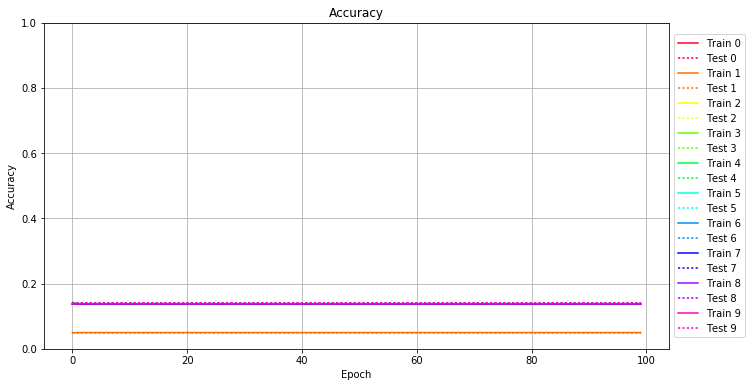

In [17]:
plot_acc(tophistory)

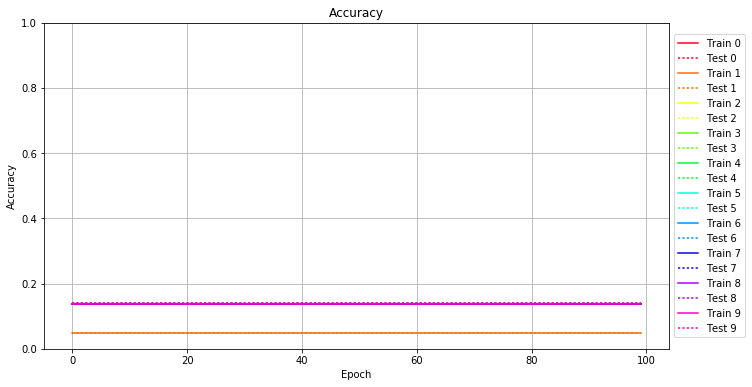

In [18]:
plot_acc(history)

In [19]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

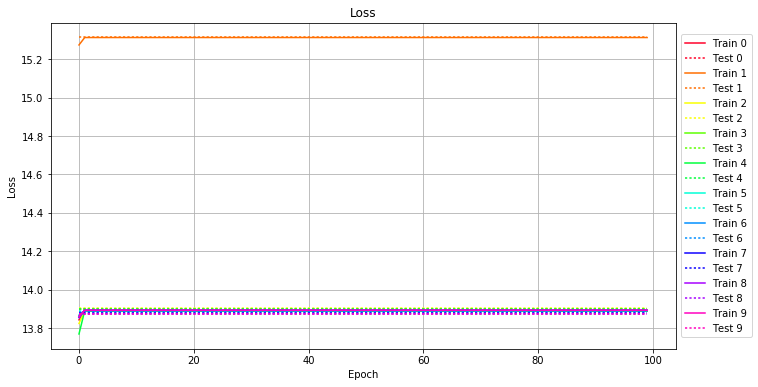

In [20]:
plot_loss(tophistory)

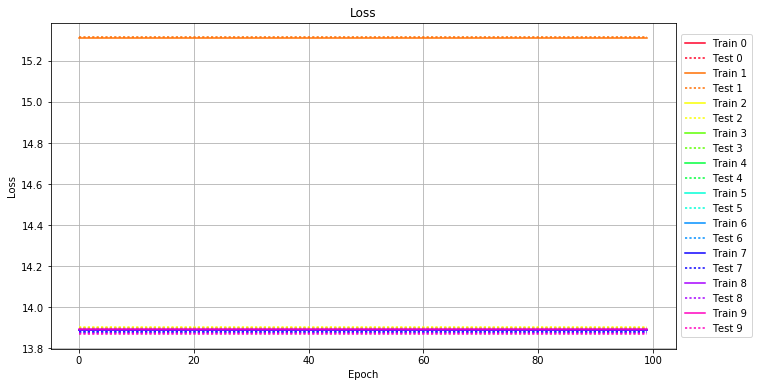

In [21]:
plot_loss(history)

Plotting the confusion matrix


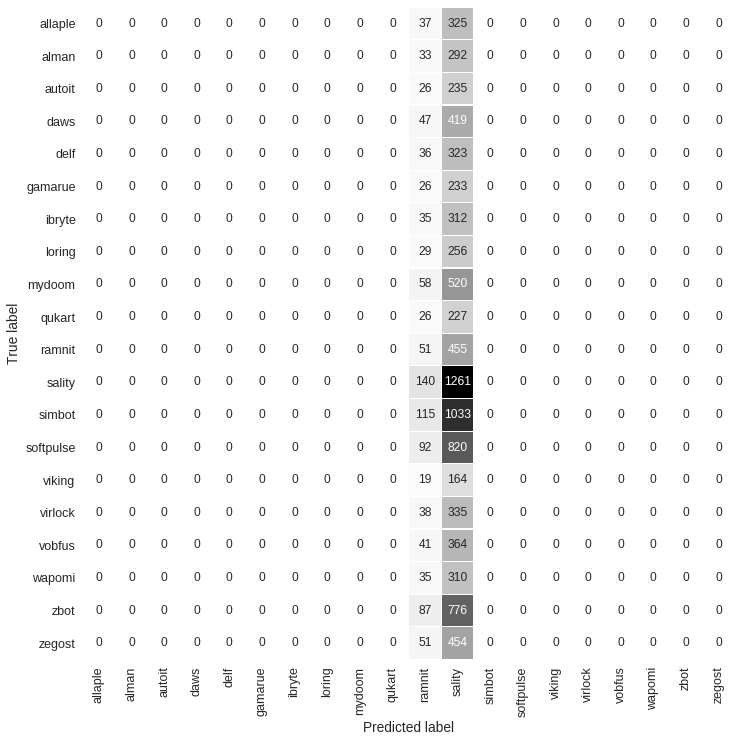

In [22]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


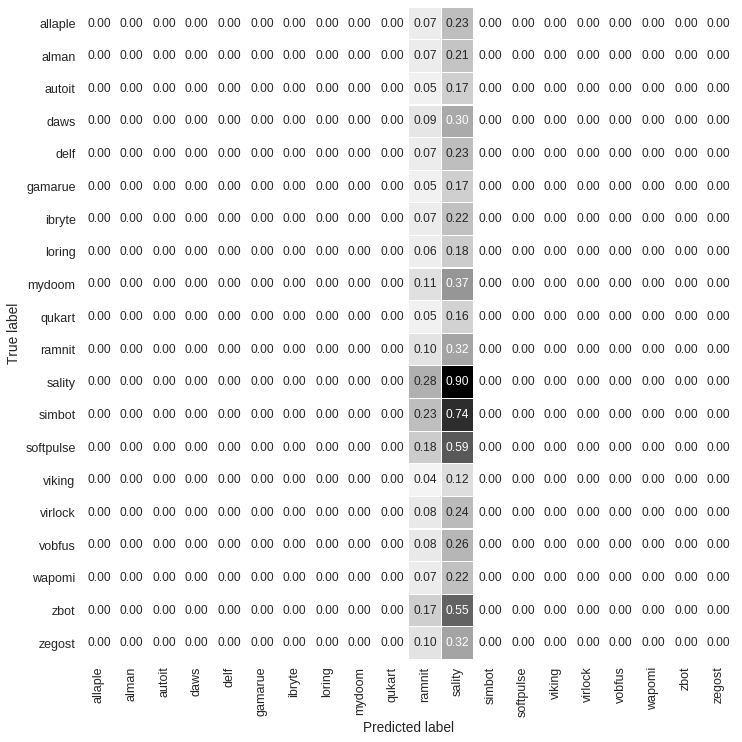

In [23]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
for h in tophistory:
    print(h.history)

{'acc': [0.13827919227392449, 0.13827919227392449, 0.13827919227719515, 0.13827919227392449, 0.13827919230008984, 0.13827919228046584, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227719515, 0.13827919230008984, 0.13827919227719515, 0.13827919227392449, 0.13827919228046584, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227719515, 0.13827919227719515, 0.13827919230008984, 0.13827919228700716, 0.13827919227719515, 0.13827919228046584, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227719515, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919232625518, 0.13827919227392449, 0.13827919227392449, 0.13827919228700716, 0.13827919232625518, 0.13827919230008984, 0.13827919228046584, 0.13827919227392449, 0.13827919228046584, 0.13827919224775914, 0.13827919228046584, 0.13827919228700716, 0.13

In [25]:
for h in history:
    print(h.history)

{'acc': [0.13827919227392449, 0.13827919227392449, 0.13827919228700716, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919227719515, 0.13827919228700716, 0.13827919228046584, 0.13827919228046584, 0.13827919227392449, 0.13827919228700716, 0.13827919228046584, 0.13827919228046584, 0.13827919227392449, 0.13827919230008984, 0.13827919228046584, 0.13827919228046584, 0.13827919228046584, 0.13827919227719515, 0.13827919230008984, 0.13827919227392449, 0.13827919230008984, 0.13827919227719515, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919228700716, 0.13827919230008984, 0.13827919230008984, 0.13827919230008984, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919228046584, 0.13827919227392449, 0.13827919228046584, 0.13827919228700716, 0.13827919227719515, 0.13827919228700716, 0.13827919230008984, 0.13827919230008984, 0.13827919227719515, 0.13827919228046584, 0.13827919228700716, 0.13

In [26]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

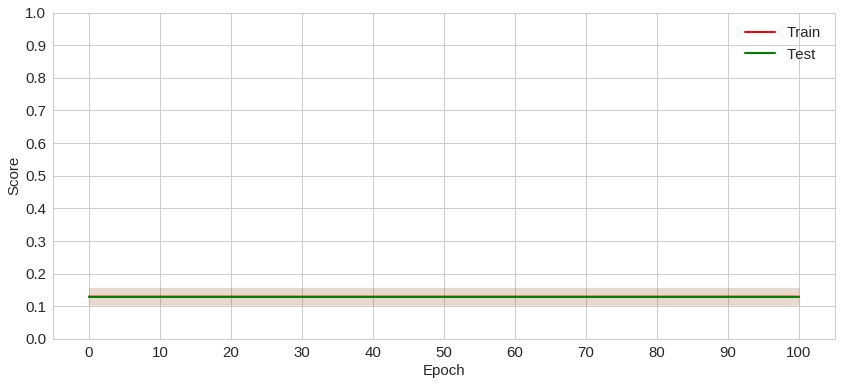

In [27]:
plot_mean_acc(tophistory)

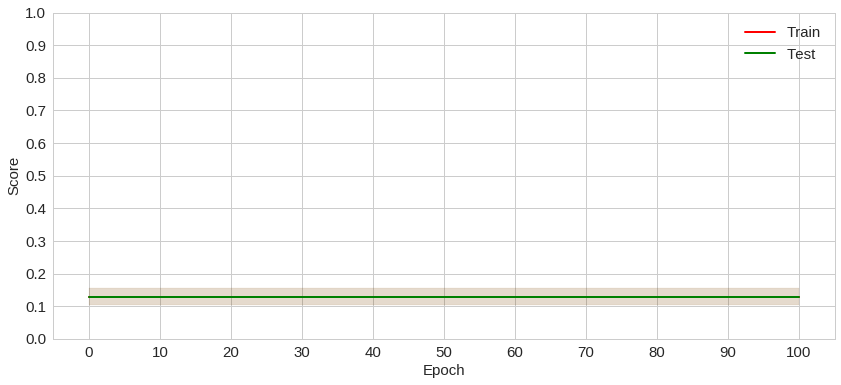

In [28]:
plot_mean_acc(history)

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

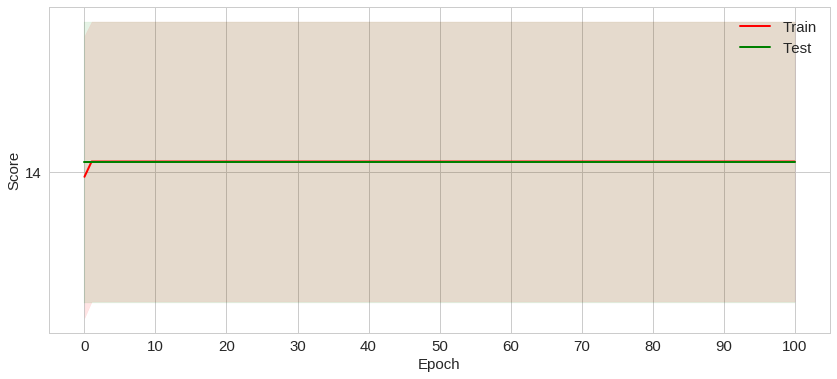

In [30]:
plot_mean_loss(tophistory)

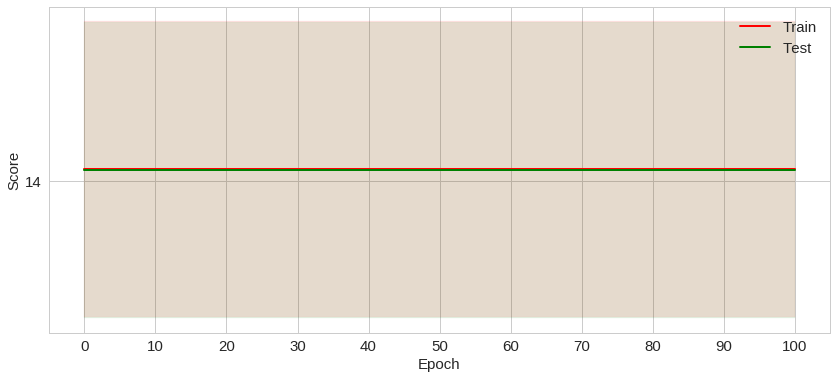

In [31]:
plot_mean_loss(history)

In [33]:
tophist = [{'acc': [0.13827919227392449, 0.13827919227392449, 0.13827919227719515, 0.13827919227392449, 0.13827919230008984, 0.13827919228046584, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227719515, 0.13827919230008984, 0.13827919227719515, 0.13827919227392449, 0.13827919228046584, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227719515, 0.13827919227719515, 0.13827919230008984, 0.13827919228700716, 0.13827919227719515, 0.13827919228046584, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227719515, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919232625518, 0.13827919227392449, 0.13827919227392449, 0.13827919228700716, 0.13827919232625518, 0.13827919230008984, 0.13827919228046584, 0.13827919227392449, 0.13827919228046584, 0.13827919224775914, 0.13827919228046584, 0.13827919228700716, 0.13827919227392449, 0.13827919228700716, 0.13827919227392449, 0.13827919227719515, 0.13827919230008984, 0.13827919228700716, 0.13827919228046584, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919230008984, 0.13827919228046584, 0.13827919228046584, 0.13827919228046584, 0.13827919227392449, 0.13827919228700716, 0.13827919227392449, 0.13827919228700716, 0.13827919228700716, 0.13827919227719515, 0.13827919230008984, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919228700716, 0.13827919227392449, 0.13827919227719515, 0.13827919227719515, 0.13827919227719515, 0.13827919227392449, 0.13827919232625518, 0.13827919228700716, 0.13827919230008984, 0.13827919227392449, 0.13827919232625518, 0.13827919227392449, 0.13827919227392449, 0.13827919230008984, 0.13827919228046584, 0.13827919230008984, 0.13827919227719515, 0.13827919228700716, 0.13827919228046584, 0.13827919227392449, 0.13827919228046584, 0.13827919227719515, 0.13827919227392449, 0.13827919228046584, 0.13827919228700716], 'loss': [13.842227267632891, 13.889298160208014, 13.889298103272235, 13.889298166906341, 13.889298201235269, 13.889298158533434, 13.889298133414707, 13.88929819369965, 13.889298133414707, 13.889298150997815, 13.88929818365216, 13.88929817444196, 13.889298150160524, 13.889298182814869, 13.889298151835106, 13.88929812839096, 13.889298187001323, 13.889298160208014, 13.88929813676387, 13.889298170255506, 13.889298214631921, 13.88929814597407, 13.889298190350486, 13.889298185326741, 13.889298213794632, 13.889298133414707, 13.889298215469212, 13.889298240587939, 13.88929820374714, 13.889298150997815, 13.889298140950324, 13.889298179465705, 13.889298200397977, 13.889298160208014, 13.889298200397977, 13.88929820207256, 13.889298133414707, 13.889298140113034, 13.889298159370723, 13.889298188675905, 13.88929821212005, 13.889298185326741, 13.88929814681136, 13.889298151835106, 13.889298175279251, 13.889298192025068, 13.889298179465705, 13.889298150997815, 13.889298212957341, 13.88929820207256, 13.88929813676387, 13.889298171930086, 13.88929816606905, 13.889298185326741, 13.88929819369965, 13.889298133414707, 13.88929819369965, 13.889298151835106, 13.889298165231759, 13.889298205421722, 13.889298178628414, 13.889298228865867, 13.88929816606905, 13.889298187001323, 13.889298192862359, 13.889298186164032, 13.88929813676387, 13.889298131740125, 13.889298233889612, 13.88929812671638, 13.889298217981086, 13.889298187001323, 13.889298181977578, 13.889298207096305, 13.889298124204506, 13.889298112482434, 13.889298181977578, 13.88929813676387, 13.889298163557179, 13.889298116668888, 13.889298168580924, 13.889298155184269, 13.889298226353995, 13.889298154346978, 13.889298204584431, 13.889298161882596, 13.889298120018053, 13.889298187001323, 13.889298207933596, 13.889298192025068, 13.889298154346978, 13.889298143462197, 13.889298219655668, 13.889298171930086, 13.889298180302996, 13.889298151835106, 13.88929818365216, 13.889298130902834, 13.889298192025068, 13.88929814597407], 'val_acc': [0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125], 'val_loss': [13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467]},
{'acc': [0.049594031164938872, 0.049923195088572847, 0.049923195088572847, 0.049923195092660279, 0.049923195084485408, 0.049923195088572847, 0.049923195088572847, 0.049923195084485408, 0.049923195084485408, 0.049923195088572847, 0.049923195084485408, 0.049923195088572847, 0.049923195100835156, 0.049923195084485408, 0.049923195092660279, 0.049923195092660279, 0.049923195092660279, 0.049923195084485408, 0.049923195088572847, 0.049923195092660279, 0.049923195100835156, 0.049923195092660279, 0.049923195084485408, 0.049923195092660279, 0.049923195084485408, 0.049923195092660279, 0.049923195092660279, 0.049923195084485408, 0.049923195084485408, 0.049923195088572847, 0.049923195107375057, 0.049923195084485408, 0.049923195092660279, 0.049923195088572847, 0.049923195084485408, 0.049923195088572847, 0.049923195084485408, 0.049923195092660279, 0.049923195084485408, 0.049923195092660279, 0.049923195084485408, 0.049923195100835156, 0.049923195084485408, 0.049923195092660279, 0.049923195084485408, 0.049923195088572847, 0.049923195088572847, 0.049923195092660279, 0.049923195088572847, 0.049923195088572847, 0.049923195084485408, 0.049923195088572847, 0.049923195084485408, 0.049923195088572847, 0.049923195084485408, 0.049923195084485408, 0.049923195084485408, 0.049923195088572847, 0.049923195107375057, 0.049923195084485408, 0.049923195084485408, 0.049923195088572847, 0.049923195088572847, 0.049923195100835156, 0.049923195092660279, 0.049923195088572847, 0.049923195100835156, 0.049923195088572847, 0.049923195092660279, 0.049923195092660279, 0.049923195088572847, 0.049923195100835156, 0.049923195092660279, 0.049923195092660279, 0.049923195107375057, 0.049923195088572847, 0.049923195084485408, 0.049923195094295256, 0.049923195084485408, 0.049923195092660279, 0.049923195084485408, 0.049923195084485408, 0.049923195084485408, 0.049923195088572847, 0.049923195092660279, 0.049923195092660279, 0.049923195088572847, 0.049923195088572847, 0.049923195088572847, 0.049923195088572847, 0.049923195100835156, 0.049923195088572847, 0.049923195092660279, 0.049923195084485408, 0.049923195092660279, 0.049923195092660279, 0.049923195092660279, 0.049923195107375057, 0.049923195092660279, 0.049923195088572847], 'loss': [15.274726557946137, 15.313428291553517, 15.313428318340945, 15.31342829322773, 15.313428323363588, 15.313428311644088, 15.313428338431518, 15.313428303273017, 15.313428283182445, 15.313428331734659, 15.313428323363588, 15.313428291553517, 15.313428307249275, 15.31342831666673, 15.313428326712017, 15.313428286530874, 15.313428333408874, 15.313428309969874, 15.313428331734659, 15.313428320015159, 15.313428313946133, 15.313428286530874, 15.313428330060445, 15.313428313318303, 15.313428303273017, 15.313428297203989, 15.313428313318303, 15.31342831666673, 15.313428309969874, 15.313428291553517, 15.313428325665633, 15.313428370241589, 15.313428299924588, 15.313428298250374, 15.31342831666673, 15.313428325037803, 15.313428303273017, 15.313428323991419, 15.313428330060445, 15.31342829322773, 15.31342831666673, 15.313428347430419, 15.313428350151018, 15.313428320015159, 15.313428309969874, 15.313428278159803, 15.313428338431518, 15.313428283810275, 15.313428345128374, 15.313428291553517, 15.313428330060445, 15.313428371915803, 15.313428296576159, 15.313428284856659, 15.313428336757303, 15.313428303273017, 15.313428283182445, 15.313428298250374, 15.313428318968775, 15.313428336757303, 15.313428289879303, 15.313428318340945, 15.313428291553517, 15.31342829385556, 15.313428306621445, 15.313428325037803, 15.31342832064299, 15.313428331734659, 15.313428299924588, 15.313428313318303, 15.313428278159803, 15.313428284438105, 15.313428320015159, 15.313428306621445, 15.313428314992517, 15.313428298250374, 15.313428309969874, 15.313428322317204, 15.313428296576159, 15.313428364172562, 15.313428296576159, 15.313428276485588, 15.313428276485588, 15.313428278159803, 15.313428313318303, 15.313428326712017, 15.313428291553517, 15.313428331734659, 15.313428298250374, 15.313428311644088, 15.31342832064299, 15.313428338431518, 15.313428323991419, 15.313428330060445, 15.313428283810275, 15.31342829322773, 15.313428313318303, 15.313428292181348, 15.313428326712017, 15.313428338431518], 'val_acc': [0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667], 'val_loss': [15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911]},
{'acc': [0.13964458096963683, 0.13832821415515781, 0.13832821413881163, 0.13832821413881163, 0.13832821422054245, 0.13832821415515781, 0.13832821414861934, 0.13832821411592702, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821415515781, 0.13832821414861934, 0.13832821415515781, 0.13832821414208088, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821416823474, 0.13832821418131167, 0.13832821413881163, 0.13832821414208088, 0.13832821414208088, 0.13832821415515781, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821414208088, 0.13832821415515781, 0.13832821418131167, 0.13832821415515781, 0.13832821414208088, 0.13832821413881163, 0.13832821418131167, 0.13832821414208088, 0.13832821415515781, 0.13832821413881163, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821415515781, 0.13832821414208088, 0.13832821415515781, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821414861934, 0.13832821413554242, 0.13832821413881163, 0.13832821412900395, 0.13832821416823474, 0.13832821414208088, 0.13832821413881163, 0.13832821415515781, 0.13832821415515781, 0.13832821413881163, 0.13832821418131167, 0.13832821414208088, 0.13832821418131167, 0.13832821413390781, 0.13832821414208088, 0.13832821413881163, 0.13832821414861934, 0.13832821413390781, 0.13832821416823474, 0.13832821415515781, 0.13832821413390781, 0.13832821413390781, 0.13832821413881163, 0.13832821413390781, 0.13832821414861934, 0.13832821418131167, 0.13832821413390781, 0.13832821414861934, 0.13832821413390781, 0.13832821416823474, 0.13832821414208088, 0.13832821412900395, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821413554242, 0.13832821413881163, 0.13832821414208088, 0.13832821415515781, 0.13832821412900395, 0.13832821413554242, 0.13832821415515781, 0.13832821413881163, 0.13832821414861934, 0.13832821415515781, 0.13832821415515781, 0.13832821414861934, 0.13832821415515781, 0.13832821413390781], 'loss': [13.823274568069813, 13.888507992826883, 13.888508036346904, 13.888507996174576, 13.888508061454608, 13.888508006217659, 13.888508033417672, 13.888507995337653, 13.888508040531521, 13.888508020026896, 13.888507966463793, 13.888508099953089, 13.888508006636121, 13.88850799952227, 13.88850801374997, 13.888508033836134, 13.888507999940732, 13.888508046808449, 13.888507997848423, 13.888507973996104, 13.88850801626074, 13.888508007054583, 13.888508060617685, 13.88850799952227, 13.888508007054583, 13.888508053503836, 13.888507979854568, 13.888508020445357, 13.888508053085374, 13.888508050574604, 13.888508039694598, 13.888508007054583, 13.888508043042291, 13.888508034254595, 13.88850804722691, 13.888508046389987, 13.888508063128455, 13.888508114180789, 13.888508040113059, 13.888508020026896, 13.888508026303823, 13.888508020445357, 13.888507978599183, 13.888508033836134, 13.888507986549957, 13.888508063965379, 13.888508069823844, 13.888508060617685, 13.888507990316112, 13.888508034254595, 13.88850801626074, 13.888508017516125, 13.888507984457648, 13.888508027140746, 13.888508096605396, 13.888508006217659, 13.888508066476151, 13.88850801626074, 13.888508023793053, 13.88850804722691, 13.888508057269991, 13.88850810957771, 13.888508060617685, 13.888508009565353, 13.888508100371551, 13.888508049319219, 13.88850804471614, 13.888507959349942, 13.888508015842278, 13.888508002451504, 13.888508076519232, 13.888508102882321, 13.888507999940732, 13.888508037183827, 13.888508022537666, 13.888508006636121, 13.888508022537666, 13.888508038020751, 13.888508027140746, 13.888508035509981, 13.888508066894612, 13.888507989479189, 13.888508033836134, 13.88850804722691, 13.888508037183827, 13.888508033417672, 13.888508067731536, 13.88850801626074, 13.888507966882255, 13.888508046389987, 13.88850802797767, 13.888508061036147, 13.888508053085374, 13.888508002869965, 13.888508020026896, 13.88850803299921, 13.888508006217659, 13.888508086980776, 13.888508006217659, 13.888508022537666], 'val_acc': [0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433], 'val_loss': [13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101]},
{'acc': [0.13739035087719298, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912], 'loss': [13.862196959110728, 13.889485978243643, 13.889485938088935, 13.889485907972904, 13.889485951473839, 13.889485941435161, 13.889485918011582, 13.889485891241776, 13.889485891241776, 13.889485931396484, 13.889485938088935, 13.889485867818196, 13.889485918011582, 13.88948590462668, 13.889485944781388, 13.889485921357807, 13.889485961512515, 13.889485968204967, 13.889485924704033, 13.889485911319131, 13.889485978243643, 13.889485921357807, 13.889485948127613, 13.889485897934227, 13.889485884549325, 13.88948586447197, 13.88948590462668, 13.889485948127613, 13.889485881203099, 13.88948590462668, 13.889485944781388, 13.889485938088935, 13.889485931396484, 13.889485954820064, 13.889485827663488, 13.889485911319131, 13.88948595816629, 13.889485918011582, 13.889485921357807, 13.889485894588002, 13.889485974897418, 13.889485887895551, 13.889485948127613, 13.889485978243643, 13.88948590462668, 13.889485931396484, 13.88948595816629, 13.889485884549325, 13.889485881203099, 13.889485891241776, 13.889485881203099, 13.889485921357807, 13.889485857779519, 13.889485911319131, 13.889485897934227, 13.889485907972904, 13.889485938088935, 13.889485847740843, 13.889485938088935, 13.889485877856874, 13.889485861125745, 13.889485931396484, 13.889485911319131, 13.889485877856874, 13.889485877856874, 13.889485971551192, 13.889485891241776, 13.889485974897418, 13.889485938088935, 13.889485914665356, 13.889485918011582, 13.889485837702166, 13.889485971551192, 13.889485938088935, 13.889485931396484, 13.889485924704033, 13.889485867818196, 13.889485911319131, 13.889485918011582, 13.889485907972904, 13.889485911319131, 13.889485901280453, 13.889485944781388, 13.889485924704033, 13.889485891241776, 13.889485951473839, 13.88948590462668, 13.88948590462668, 13.889485877856874, 13.889485867818196, 13.889485984936096, 13.889485924704033, 13.889485928050259, 13.889485998320998, 13.889485961512515, 13.889485867818196, 13.889485901280453, 13.88948590462668, 13.889485921357807, 13.889485921357807], 'val_acc': [0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119], 'val_loss': [13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244]},
{'acc': [0.14287280701754385, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912], 'loss': [13.768598790754352, 13.889485968204967, 13.889485901280453, 13.889485918011582, 13.889485911319131, 13.889485914665356, 13.889485981589869, 13.889485814278586, 13.889485891241776, 13.889485938088935, 13.889485918011582, 13.88948593474271, 13.889485918011582, 13.889485884549325, 13.889485877856874, 13.889485881203099, 13.889485907972904, 13.889485884549325, 13.889485938088935, 13.889485928050259, 13.889485961512515, 13.889485951473839, 13.889485948127613, 13.889485938088935, 13.88948586447197, 13.889485921357807, 13.889485931396484, 13.889485911319131, 13.889485924704033, 13.889485911319131, 13.88948586447197, 13.889485901280453, 13.88948586447197, 13.889485874510648, 13.889485931396484, 13.889485871164423, 13.889485911319131, 13.889485877856874, 13.889485938088935, 13.889485918011582, 13.889485951473839, 13.889485881203099, 13.889485951473839, 13.889485874510648, 13.889485938088935, 13.889485907972904, 13.889485938088935, 13.889485944781388, 13.889485871164423, 13.889485964858741, 13.889485911319131, 13.889485951473839, 13.889485991628547, 13.889485931396484, 13.889485871164423, 13.889485964858741, 13.889485944781388, 13.889485921357807, 13.889485954820064, 13.889485857779519, 13.889485897934227, 13.88948595816629, 13.889485861125745, 13.889485851087068, 13.889485968204967, 13.889485984936096, 13.88948590462668, 13.889485884549325, 13.889485931396484, 13.88948593474271, 13.889485907972904, 13.889485884549325, 13.889485991628547, 13.889485938088935, 13.889485891241776, 13.889485938088935, 13.88948590462668, 13.889485991628547, 13.889485887895551, 13.889485914665356, 13.889485924704033, 13.889485931396484, 13.88948590462668, 13.889485991628547, 13.889485884549325, 13.889485918011582, 13.889485891241776, 13.889485911319131, 13.889485954820064, 13.889485944781388, 13.88948593474271, 13.889485944781388, 13.889485884549325, 13.889485928050259, 13.889485918011582, 13.889485887895551, 13.889485851087068, 13.88948590462668, 13.889485951473839, 13.88948593474271], 'val_acc': [0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119], 'val_loss': [13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244]},
{'acc': [0.13775342468366231, 0.13819178084314687, 0.13819178085784389, 0.13819178083743133, 0.13819178094929213, 0.13819178085784389, 0.13819178083743133, 0.13819178085784389, 0.13819178084804587, 0.13819178082722508, 0.1381917808529449, 0.13819178084314687, 0.1381917808529449, 0.13819178084804587, 0.13819178082457145, 0.13819178085784389, 0.13819178083824785, 0.13819178084314687, 0.13819178082722508, 0.13819178085784389, 0.13819178085784389, 0.13819178083253233, 0.13819178083253233, 0.13819178082722508, 0.13819178083253233, 0.13819178083743133, 0.13819178084314687, 0.13819178085784389, 0.13819178082457145, 0.13819178083253233, 0.1381917808529449, 0.13819178085784389, 0.13819178083253233, 0.13819178082457145, 0.13819178083253233, 0.13819178083253233, 0.13819178084804587, 0.13819178085784389, 0.13819178083743133, 0.13819178084314687, 0.1381917808529449, 0.1381917808529449, 0.1381917808529449, 0.13819178085784389, 0.13819178085784389, 0.13819178083253233, 0.13819178083824785, 0.13819178083743133, 0.13819178083253233, 0.13819178083253233, 0.13819178082722508, 0.13819178085784389, 0.1381917808529449, 0.1381917808529449, 0.13819178083743133, 0.13819178083253233, 0.13819178083253233, 0.13819178083253233, 0.13819178084314687, 0.13819178082457145, 0.13819178082722508, 0.13819178084314687, 0.13819178084804587, 0.13819178084314687, 0.1381917808529449, 0.13819178082457145, 0.1381917808529449, 0.13819178083253233, 0.13819178082722508, 0.13819178083253233, 0.13819178085784389, 0.13819178083253233, 0.13819178085784389, 0.13819178084314687, 0.13819178083253233, 0.13819178085784389, 0.13819178083253233, 0.13819178085784389, 0.1381917808529449, 0.13819178083253233, 0.13819178085784389, 0.13819178085784389, 0.13819178082722508, 0.13819178083253233, 0.13819178083743133, 0.13819178083743133, 0.13819178083743133, 0.13819178085784389, 0.13819178084804587, 0.13819178083743133, 0.13819178084314687, 0.13819178085784389, 0.13819178085784389, 0.13819178082844982, 0.13819178082457145, 0.1381917808529449, 0.13819178088397197, 0.13819178083253233, 0.13819178084804587, 0.13819178083824785], 'loss': [13.853791871789383, 13.890707042955372, 13.890707102527356, 13.890707013273893, 13.890707009093402, 13.890707055705867, 13.890707133672009, 13.890707089149789, 13.890707017872431, 13.890707082879054, 13.890707047344888, 13.890707085909909, 13.89070707023307, 13.890707151648117, 13.890707092285156, 13.890707042328298, 13.890707060304406, 13.890707089776862, 13.890707002613642, 13.890707042328298, 13.890707015573161, 13.890707085178324, 13.890707131999813, 13.890707089567838, 13.890707105244676, 13.890707053406597, 13.890707052465988, 13.890707028950731, 13.89070705215245, 13.890707054556232, 13.890707047344888, 13.890707028950731, 13.890707045045618, 13.890707058841235, 13.890707067933802, 13.890707027801096, 13.890707111515411, 13.890707049017083, 13.890707126983225, 13.890707083088078, 13.890707063544287, 13.890707157187267, 13.890707076921855, 13.890707069083437, 13.890707008884378, 13.890707118622243, 13.890707013482917, 13.89070712029444, 13.890707061245017, 13.890707098555891, 13.890707036057563, 13.890707028950731, 13.890707090299424, 13.890707020589749, 13.890707093539303, 13.890707058423185, 13.890707114755291, 13.890707011601696, 13.890707019022067, 13.890707072218804, 13.890707056123917, 13.890707032399634, 13.890707111515411, 13.890707039088419, 13.890707043477933, 13.890706998642177, 13.89070703678915, 13.890707031668049, 13.890707082879054, 13.890707105244676, 13.890707082461004, 13.890707038356833, 13.890707082461004, 13.890707083088078, 13.890707111933461, 13.890707055705867, 13.890707051734402, 13.890707015573161, 13.890707043477933, 13.890707071800755, 13.890707102527356, 13.890707002195594, 13.890707036057563, 13.890707071800755, 13.890707060095382, 13.890707086850519, 13.890707046717814, 13.890707042328298, 13.890707084760274, 13.890707080161734, 13.890707085909909, 13.890707082461004, 13.890707082461004, 13.890707029159755, 13.890707085596372, 13.890707047344888, 13.890707103886017, 13.890707088000154, 13.890707058005137, 13.89070708037076], 'val_acc': [0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817], 'val_loss': [13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505]},
{'acc': [0.13739454367390805, 0.13816149892466895, 0.13816149886181206, 0.13816149885528148, 0.13816149886181206, 0.13816149886752632, 0.13816149886099574, 0.1381614988740569, 0.13816149886099574, 0.13816149885528148, 0.13816149892466895, 0.13816149885446516, 0.1381614988740569, 0.13816149886181206, 0.13816149888058749, 0.13816149886181206, 0.13816149886752632, 0.13816149888058749, 0.13816149886752632, 0.13816149886099574, 0.13816149886181206, 0.13816149886099574, 0.13816149885242435, 0.13816149886099574, 0.13816149886752632, 0.13816149885528148, 0.13816149885446516, 0.13816149886752632, 0.1381614988740569, 0.13816149891813836, 0.13816149886181206, 0.13816149891160778, 0.13816149886181206, 0.13816149886181206, 0.1381614988740569, 0.13816149886099574, 0.13816149886752632, 0.1381614988740569, 0.13816149885242435, 0.13816149886752632, 0.13816149888058749, 0.13816149886752632, 0.13816149885528148, 0.1381614988740569, 0.13816149886099574, 0.13816149885528148, 0.13816149885446516, 0.13816149888058749, 0.1381614988740569, 0.13816149886752632, 0.1381614988509958, 0.13816149888058749, 0.1381614988509958, 0.13816149885528148, 0.13816149888058749, 0.13816149885528148, 0.13816149886181206, 0.13816149886099574, 0.13816149886752632, 0.13816149886752632, 0.13816149885242435, 0.13816149886181206, 0.13816149886181206, 0.13816149886099574, 0.13816149886099574, 0.13816149892466895, 0.13816149885528148, 0.13816149888058749, 0.13816149888058749, 0.1381614988740569, 0.13816149886181206, 0.13816149886181206, 0.13816149886752632, 0.13816149885528148, 0.1381614988740569, 0.13816149885528148, 0.13816149888058749, 0.13816149888058749, 0.13816149886181206, 0.1381614988740569, 0.13816149885528148, 0.13816149886181206, 0.13816149885242435, 0.13816149885528148, 0.13816149888058749, 0.1381614988740569, 0.13816149888058749, 0.13816149892466895, 0.13816149888058749, 0.13816149888058749, 0.13816149885242435, 0.13816149885528148, 0.13816149886099574, 0.13816149889854659, 0.1381614988509958, 0.13816149886099574, 0.13816149886181206, 0.13816149885528148, 0.13816149888058749, 0.1381614988740569], 'loss': [13.86673196571294, 13.891195137476991, 13.891195129117843, 13.891195157538947, 13.891195195991029, 13.891195149179799, 13.891195130789674, 13.891195140820651, 13.891195140089225, 13.891195130789674, 13.891195170913583, 13.89119519264737, 13.891195120758695, 13.891195162554435, 13.891195185960051, 13.891195082306615, 13.891195200066113, 13.891195203409772, 13.891195155867118, 13.891195157538947, 13.891195166629521, 13.891195204350177, 13.89119509400942, 13.891195170913583, 13.89119517331684, 13.891195117415036, 13.891195112399547, 13.891195138417396, 13.891195205081603, 13.89119516182301, 13.891195182616391, 13.891195120758695, 13.891195180004157, 13.89119518930371, 13.891195150120204, 13.891195099965314, 13.891195175929074, 13.891195174257243, 13.891195167569926, 13.891195165166669, 13.89119516997318, 13.89119514249248, 13.891195197662858, 13.891195127446014, 13.891195160151181, 13.891195181675988, 13.89119516182301, 13.89119519264737, 13.891195114071376, 13.891195153254884, 13.891195096412677, 13.89119519264737, 13.891195149911225, 13.891195170913583, 13.891195163285861, 13.891195090665763, 13.89119518930371, 13.891195204350177, 13.891195102368568, 13.891195175929074, 13.891195191706965, 13.891195126505609, 13.891195169241755, 13.891195157538947, 13.891195200275092, 13.891195221799899, 13.891195157538947, 13.891195206022006, 13.891195139148822, 13.891195178332328, 13.891195162554435, 13.891195193378795, 13.89119518930371, 13.891195134864757, 13.891195187631881, 13.891195184288222, 13.891195119086866, 13.891195109787313, 13.891195209365666, 13.891195160882607, 13.891195184288222, 13.891195135805162, 13.89119514750797, 13.891195170913583, 13.891195183347817, 13.891195160882607, 13.891195159210778, 13.891195211037495, 13.891195152523458, 13.891195132461503, 13.891195118146461, 13.891195204350177, 13.89119509735308, 13.891195115952184, 13.891195176660499, 13.89119523109945, 13.891195169241755, 13.891195228487216, 13.891195145836139, 13.891195183556796], 'val_acc': [0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688], 'val_loss': [13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347]},
{'acc': [0.13726993865193921, 0.13814636289185334, 0.13814636283961437, 0.13814636283961437, 0.13814636284614423, 0.13814636283961437, 0.13814636284287932, 0.13814636284287932, 0.13814636285267412, 0.13814636286573384, 0.13814636285267412, 0.13814636289185334, 0.13814636283961437, 0.13814636285267412, 0.1381463629179728, 0.13814636289185334, 0.13814636282655463, 0.13814636285267412, 0.13814636283961437, 0.13814636282655463, 0.13814636285267412, 0.13814636286573384, 0.13814636289185334, 0.13814636284614423, 0.13814636281349491, 0.13814636284614423, 0.13814636282655463, 0.13814636286573384, 0.13814636282655463, 0.13814636286573384, 0.13814636283961437, 0.13814636289185334, 0.13814636284287932, 0.13814636283961437, 0.13814636283961437, 0.13814636289185334, 0.13814636283961437, 0.13814636285267412, 0.13814636286573384, 0.13814636284614423, 0.13814636283961437, 0.13814636283961437, 0.13814636286573384, 0.13814636284614423, 0.13814636285267412, 0.13814636284287932, 0.13814636285267412, 0.13814636283961437, 0.13814636284614423, 0.13814636289185334, 0.13814636286573384, 0.13814636283961437, 0.13814636286573384, 0.13814636284614423, 0.13814636286573384, 0.13814636289185334, 0.13814636286573384, 0.13814636284614423, 0.13814636282655463, 0.13814636287879359, 0.13814636285267412, 0.13814636289185334, 0.13814636284614423, 0.13814636286573384, 0.13814636284614423, 0.13814636286573384, 0.13814636283961437, 0.13814636284124684, 0.13814636284614423, 0.13814636282655463, 0.13814636285267412, 0.13814636284124684, 0.13814636284124684, 0.13814636282655463, 0.13814636283961437, 0.13814636284287932, 0.13814636283961437, 0.1381463629179728, 0.13814636286573384, 0.13814636289185334, 0.13814636283961437, 0.13814636285267412, 0.13814636284614423, 0.13814636284614423, 0.13814636283961437, 0.13814636283961437, 0.13814636289185334, 0.13814636283961437, 0.1381463629179728, 0.13814636286573384, 0.13814636282655463, 0.13814636285267412, 0.13814636286573384, 0.13814636289185334, 0.13814636281349491, 0.13814636284287932, 0.13814636286573384, 0.13814636283961437, 0.13814636281349491, 0.13814636284614423], 'loss': [13.856942983388274, 13.891439103536914, 13.891439146999723, 13.891439126939966, 13.891439080969688, 13.891439109387678, 13.891439108551854, 13.891439088492097, 13.891439183775946, 13.89143908180551, 13.89143906090993, 13.891439163716189, 13.891439116074263, 13.891439074283102, 13.891439131954906, 13.891439099357799, 13.891439146163901, 13.891439074283102, 13.891439116074263, 13.891439083477158, 13.891439170402775, 13.891439135298198, 13.891439096850329, 13.891439114402617, 13.891439129447436, 13.891439138641491, 13.891439126104142, 13.891439128611612, 13.891439119417557, 13.891439144492255, 13.891439146999723, 13.891439130283258, 13.891439141984785, 13.891439162880365, 13.891439146999723, 13.891439136969845, 13.891439096014507, 13.891439130283258, 13.891439095178683, 13.891439138641491, 13.891439213865583, 13.891439193805825, 13.891439101865268, 13.891439087656273, 13.891439070103985, 13.891439108551854, 13.891439143656431, 13.891439060074106, 13.891439105208562, 13.89143917708936, 13.891439055059168, 13.89143912276085, 13.891439121925027, 13.891439125268318, 13.891439108551854, 13.891439143656431, 13.891439164552011, 13.891439145328077, 13.891439172910244, 13.891439116074263, 13.891439132790728, 13.89143914867137, 13.891439111895147, 13.891439188790885, 13.891439078462218, 13.891439090999567, 13.891439113566793, 13.89143915368631, 13.891439080969688, 13.891439172910244, 13.891439096850329, 13.891439126939966, 13.89143908682045, 13.891439166223659, 13.891439180432654, 13.891439088492097, 13.891439169566951, 13.891439078462218, 13.89143908180551, 13.89143917708936, 13.891439106880208, 13.891439070103985, 13.891439111895147, 13.891439145328077, 13.89143908682045, 13.891439162880365, 13.891439143656431, 13.891439093507037, 13.891439071775633, 13.891439111059324, 13.891439112730971, 13.891439103536914, 13.891439121925027, 13.891439036671056, 13.891439149507192, 13.891439088492097, 13.891439121925027, 13.891439106880208, 13.891439152014662, 13.891439091835389], 'val_acc': [0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889], 'val_loss': [13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782]},
{'acc': [0.13767798468062545, 0.13811610078955272, 0.13811610078302428, 0.13811610079608114, 0.138116100838516, 0.13811610080260958, 0.13811610077078346, 0.138116100838516, 0.13811610078955272, 0.13811610078302428, 0.138116100838516, 0.13811610084504444, 0.13811610080260958, 0.13811610078139216, 0.13811610076833528, 0.13811610076833528, 0.13811610076833528, 0.13811610077486372, 0.13811610076833528, 0.13811610078139216, 0.13811610084504444, 0.13811610080260958, 0.13811610077486372, 0.13811610078302428, 0.13811610077486372, 0.13811610078302428, 0.13811610080260958, 0.13811610077078346, 0.13811610077486372, 0.13811610078955272, 0.13811610078955272, 0.13811610079608114, 0.13811610077486372, 0.13811610078955272, 0.13811610077078346, 0.13811610079608114, 0.13811610077486372, 0.13811610078139216, 0.13811610078955272, 0.13811610077486372, 0.13811610077486372, 0.13811610079608114, 0.13811610079608114, 0.13811610079608114, 0.13811610082545914, 0.13811610078139216, 0.13811610080260958, 0.13811610083198755, 0.13811610078302428, 0.13811610078139216, 0.13811610079608114, 0.13811610076833528, 0.13811610077078346, 0.13811610077486372, 0.13811610079608114, 0.13811610079608114, 0.13811610079608114, 0.13811610078955272, 0.13811610079608114, 0.13811610077486372, 0.13811610079608114, 0.13811610077486372, 0.13811610078139216, 0.13811610079608114, 0.13811610080260958, 0.13811610078955272, 0.13811610079608114, 0.13811610078955272, 0.13811610080260958, 0.13811610084504444, 0.13811610078955272, 0.13811610079608114, 0.13811610077486372, 0.13811610078302428, 0.13811610076996739, 0.13811610077486372, 0.13811610078302428, 0.13811610078139216, 0.13811610085157289, 0.13811610076833528, 0.13811610077486372, 0.13811610078955272, 0.13811610077649583, 0.13811610078955272, 0.13811610078302428, 0.13811610076833528, 0.13811610076833528, 0.13811610079608114, 0.13811610078955272, 0.13811610076833528, 0.13811610085157289, 0.13811610078955272, 0.13811610076833528, 0.13811610080260958, 0.13811610080260958, 0.13811610076833528, 0.13811610077486372, 0.13811610077486372, 0.13811610078302428, 0.13811610076874331], 'loss': [13.854173498373042, 13.891926892877017, 13.891926893294837, 13.891926872403833, 13.891926874075114, 13.891926825190165, 13.891926944268885, 13.891926860704871, 13.891926879506775, 13.891926859869232, 13.891926874075114, 13.89192697393411, 13.891926885356256, 13.891926897890858, 13.891926918781861, 13.891926912096739, 13.891926912096739, 13.891926858197952, 13.89192685193065, 13.891926857780131, 13.891926884729525, 13.891926825190165, 13.891926878253313, 13.891926904367068, 13.891926925049162, 13.891926940090684, 13.891926996705305, 13.891926843992069, 13.891926911678921, 13.891926846081169, 13.891926899562138, 13.891926879088954, 13.89192685151283, 13.891926879506775, 13.891926877417674, 13.891926859033591, 13.891926898308677, 13.891926951371827, 13.89192691293238, 13.891926878253313, 13.891926844827708, 13.891926899144318, 13.891926865718712, 13.891926872403833, 13.891926832502016, 13.891926904575978, 13.891926871986014, 13.891926818713953, 13.891926933405564, 13.891926877835495, 13.89192691251456, 13.891926865300892, 13.891926877417674, 13.891926891623557, 13.89192685673558, 13.891926896846307, 13.891926838978227, 13.891926899562138, 13.891926859033591, 13.891926818087224, 13.891926899144318, 13.891926842529697, 13.891926904575978, 13.891926899144318, 13.891926845245528, 13.891926892877017, 13.891926910216549, 13.891926890579006, 13.89192685861577, 13.891926864674161, 13.891926919617502, 13.8919267988675, 13.891926838142588, 13.891926873239473, 13.891926827279265, 13.891926864883072, 13.89192691105219, 13.891926904575978, 13.891926886609715, 13.891926992318194, 13.891926858197952, 13.891926832710926, 13.891926846916808, 13.891926924004613, 13.891926906665079, 13.891926912096739, 13.891926838560407, 13.891926818922864, 13.891926919617502, 13.891926892041377, 13.891926884311705, 13.891926886191895, 13.891926918781861, 13.891926836262398, 13.891926865300892, 13.89192685631776, 13.891926884938435, 13.891926884938435, 13.891926839813868, 13.891926897055217], 'val_acc': [0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785], 'val_loss': [13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872]},
{'acc': [0.1374288217421169, 0.13808585196877068, 0.13808585196877068, 0.13808585196550718, 0.13808585193613565, 0.13808585196877068, 0.13808585196550718, 0.13808585196877068, 0.13808585193613565, 0.13808585201445975, 0.13808585201445975, 0.13808585195571668, 0.13808585196877068, 0.13808585196550718, 0.13808585197529769, 0.13808585196224368, 0.13808585193613565, 0.13808585196877068, 0.13808585196877068, 0.13808585197529769, 0.13808585197529769, 0.13808585197529769, 0.13808585193613565, 0.13808585196550718, 0.13808585197529769, 0.13808585195571668, 0.13808585196877068, 0.13808585196550718, 0.13808585196550718, 0.13808585196550718, 0.13808585195898018, 0.13808585198182471, 0.13808585198835172, 0.13808585195571668, 0.13808585198182471, 0.13808585196877068, 0.13808585201445975, 0.13808585196550718, 0.13808585193613565, 0.13808585196550718, 0.13808585193613565, 0.13808585196224368, 0.13808585198182471, 0.13808585193613565, 0.13808585197529769, 0.13808585196550718, 0.13808585198835172, 0.13808585193613565, 0.13808585201445975, 0.13808585193613565, 0.13808585195571668, 0.13808585195898018, 0.13808585196877068, 0.13808585193613565, 0.13808585196877068, 0.13808585195898018, 0.13808585194918965, 0.13808585196550718, 0.13808585196877068, 0.13808585194266265, 0.13808585201445975, 0.13808585197529769, 0.13808585201445975, 0.13808585196224368, 0.13808585196550718, 0.13808585193613565, 0.13808585196550718, 0.13808585196224368, 0.13808585202751378, 0.13808585193613565, 0.13808585196224368, 0.13808585198182471, 0.13808585196877068, 0.13808585196224368, 0.13808585196224368, 0.13808585196550718, 0.13808585196550718, 0.13808585196550718, 0.13808585196877068, 0.13808585201445975, 0.13808585196877068, 0.13808585193613565, 0.13808585198182471, 0.13808585196224368, 0.13808585196877068, 0.13808585196550718, 0.13808585195898018, 0.13808585195898018, 0.13808585196877068, 0.13808585193613565, 0.13808585195898018, 0.13808585196550718, 0.13808585195898018, 0.13808585193613565, 0.13808585193613565, 0.13808585196224368, 0.13808585196877068, 0.13808585198835172, 0.13808585195898018, 0.13808585193613565], 'loss': [13.859534308725525, 13.892414432213174, 13.892414405478545, 13.892414499467472, 13.892414402972173, 13.892414452264145, 13.892414472732845, 13.892414452264145, 13.892414429706802, 13.892414455605973, 13.892414448922317, 13.892414462707359, 13.892414445580489, 13.892414423858602, 13.892414449340045, 13.892414379579375, 13.892414449757773, 13.892414398794889, 13.892414432213174, 13.892414484846974, 13.892414469391015, 13.89241443597273, 13.892414476492402, 13.892414470644201, 13.892414442656388, 13.892414395870789, 13.89241441884586, 13.892414450593231, 13.892414397123975, 13.892414379161647, 13.892414442238659, 13.892414399630345, 13.892414405478545, 13.892414449340045, 13.892414401718989, 13.892414432213174, 13.892414415504032, 13.89241450615113, 13.892414445162759, 13.892414417174946, 13.892414456441431, 13.892414493201544, 13.892414453099603, 13.892414438479102, 13.892414422605416, 13.892414452681873, 13.89241443889683, 13.892414476492402, 13.892414402136717, 13.892414382921203, 13.892414456023703, 13.892414400048073, 13.892414472315116, 13.892414463125087, 13.892414465631459, 13.892414366629788, 13.892414492783816, 13.892414412579932, 13.892414505733402, 13.892414455605973, 13.892414426782702, 13.892414402554445, 13.892414455605973, 13.892414419681316, 13.892414385845303, 13.892414516594345, 13.892414439314559, 13.892414459783259, 13.892414405060817, 13.892414396288517, 13.892414406314003, 13.892414435137274, 13.89241437206026, 13.892414473150573, 13.892414453099603, 13.892414417174946, 13.892414466049187, 13.892414405896274, 13.89241441007356, 13.892414448922317, 13.892414398794889, 13.892414463125087, 13.892414481922874, 13.892414392946689, 13.892414543746701, 13.892414479416502, 13.892414462289631, 13.892414462289631, 13.89241441884586, 13.892414431795446, 13.892414406731731, 13.892414445998217, 13.89241443346636, 13.892414416339488, 13.89241448317606, 13.892414446415945, 13.892414452264145, 13.892414407567188, 13.892414493619272, 13.892414489859716], 'val_acc': [0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972], 'val_loss': [13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247]}]

In [35]:
hist = [{'acc': [0.13827919227392449, 0.13827919227392449, 0.13827919228700716, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919227719515, 0.13827919228700716, 0.13827919228046584, 0.13827919228046584, 0.13827919227392449, 0.13827919228700716, 0.13827919228046584, 0.13827919228046584, 0.13827919227392449, 0.13827919230008984, 0.13827919228046584, 0.13827919228046584, 0.13827919228046584, 0.13827919227719515, 0.13827919230008984, 0.13827919227392449, 0.13827919230008984, 0.13827919227719515, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919228700716, 0.13827919230008984, 0.13827919230008984, 0.13827919230008984, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919228046584, 0.13827919227392449, 0.13827919228046584, 0.13827919228700716, 0.13827919227719515, 0.13827919228700716, 0.13827919230008984, 0.13827919230008984, 0.13827919227719515, 0.13827919228046584, 0.13827919228700716, 0.13827919228700716, 0.13827919227719515, 0.13827919228700716, 0.13827919227392449, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919227719515, 0.13827919230008984, 0.13827919227719515, 0.13827919227392449, 0.13827919230008984, 0.13827919227392449, 0.13827919228700716, 0.13827919228046584, 0.13827919228046584, 0.13827919227392449, 0.13827919227719515, 0.13827919228046584, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919228046584, 0.13827919228700716, 0.13827919228046584, 0.13827919228700716, 0.13827919228046584, 0.13827919230008984, 0.13827919227719515, 0.13827919228700716, 0.13827919230008984, 0.13827919227719515, 0.13827919228700716, 0.13827919227719515, 0.13827919227719515, 0.13827919227719515, 0.13827919227392449, 0.13827919228046584, 0.13827919228046584, 0.13827919228700716, 0.13827919228046584, 0.13827919227392449, 0.13827919230008984, 0.13827919227392449, 0.13827919230008984, 0.13827919228046584, 0.13827919227719515, 0.13827919227392449, 0.13827919227719515, 0.13827919230008984, 0.13827919227719515, 0.13827919227392449, 0.13827919227392449], 'loss': [13.889298141787615, 13.889298168580924, 13.889298199560686, 13.889298157696143, 13.889298230540449, 13.889298119180761, 13.889298176953833, 13.889298192862359, 13.889298178628414, 13.889298165231759, 13.889298117506179, 13.889298212957341, 13.889298185326741, 13.889298238913359, 13.889298233889612, 13.889298165231759, 13.889298165231759, 13.889298171930086, 13.889298125041798, 13.88929813676387, 13.889298123367215, 13.889298153509687, 13.889298207933596, 13.88929820374714, 13.889298187001323, 13.889298161882596, 13.889298153509687, 13.889298199560686, 13.889298150160524, 13.889298192025068, 13.88929811834347, 13.88929812671638, 13.889298207096305, 13.889298166906341, 13.889298127553671, 13.88929814597407, 13.889298131740125, 13.88929812839096, 13.889298178628414, 13.889298179465705, 13.889298210445467, 13.889298212957341, 13.889298181140287, 13.889298104946816, 13.889298170255506, 13.889298178628414, 13.889298199560686, 13.889298152672398, 13.889298163557179, 13.889298112482434, 13.889298140113034, 13.88929815602156, 13.889298111645143, 13.889298125879089, 13.889298210445467, 13.889298151835106, 13.889298150160524, 13.889298140113034, 13.889298187838614, 13.88929814681136, 13.889298233052321, 13.889298178628414, 13.88929811834347, 13.889298187001323, 13.889298170255506, 13.889298165231759, 13.88929812671638, 13.889298138438452, 13.889298105784107, 13.889298192025068, 13.889298199560686, 13.88929811834347, 13.889298152672398, 13.889298145136779, 13.889298181140287, 13.889298143462197, 13.889298132577416, 13.889298192025068, 13.889298089875581, 13.889298186164032, 13.889298163557179, 13.889298123367215, 13.88929813676387, 13.889298141787615, 13.889298145136779, 13.889298218818377, 13.889298152672398, 13.889298151835106, 13.889298166906341, 13.889298138438452, 13.889298153509687, 13.889298190350486, 13.889298151835106, 13.889298123367215, 13.889298114994308, 13.889298130065542, 13.889298192025068, 13.889298170255506, 13.889298140113034, 13.889298173604669], 'val_acc': [0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125], 'val_loss': [13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467]},
{'acc': [0.049923195088572847, 0.049923195100835156, 0.049923195084485408, 0.049923195092660279, 0.049923195088572847, 0.049923195092660279, 0.049923195088572847, 0.049923195100835156, 0.049923195092660279, 0.049923195092660279, 0.049923195092660279, 0.049923195084485408, 0.049923195084485408, 0.049923195084485408, 0.049923195088572847, 0.049923195136804606, 0.049923195084485408, 0.049923195107375057, 0.049923195092660279, 0.049923195084485408, 0.049923195088572847, 0.049923195084485408, 0.049923195092660279, 0.049923195088572847, 0.049923195084485408, 0.049923195088572847, 0.049923195092660279, 0.049923195092660279, 0.049923195084485408, 0.049923195107375057, 0.049923195084485408, 0.049923195084485408, 0.049923195088572847, 0.049923195107375057, 0.049923195088572847, 0.049923195088572847, 0.049923195092660279, 0.049923195092660279, 0.049923195084485408, 0.049923195088572847, 0.049923195088572847, 0.049923195088572847, 0.049923195084485408, 0.049923195092660279, 0.049923195092660279, 0.049923195088572847, 0.049923195107375057, 0.049923195092660279, 0.049923195092660279, 0.049923195084485408, 0.049923195092660279, 0.049923195088572847, 0.049923195084485408, 0.049923195092660279, 0.049923195084485408, 0.049923195084485408, 0.049923195084485408, 0.049923195107375057, 0.049923195088572847, 0.049923195084485408, 0.049923195084485408, 0.049923195088572847, 0.049923195088572847, 0.049923195092660279, 0.049923195088572847, 0.049923195092660279, 0.049923195084485408, 0.049923195088572847, 0.049923195107375057, 0.049923195092660279, 0.049923195084485408, 0.049923195092660279, 0.049923195084485408, 0.049923195084485408, 0.049923195084485408, 0.049923195092660279, 0.049923195088572847, 0.049923195084485408, 0.049923195088572847, 0.049923195084485408, 0.049923195092660279, 0.049923195088572847, 0.049923195107375057, 0.049923195084485408, 0.049923195088572847, 0.049923195092660279, 0.049923195088572847, 0.049923195088572847, 0.049923195084485408, 0.049923195088572847, 0.049923195092660279, 0.049923195084485408, 0.049923195084485408, 0.049923195088572847, 0.049923195092660279, 0.049923195092660279, 0.049923195084485408, 0.049923195084485408, 0.049923195100835156, 0.049923195092660279], 'loss': [15.313428318340945, 15.313428311225534, 15.313428296576159, 15.31342831729456, 15.31342830494723, 15.313428330688275, 15.313428278159803, 15.313428300552419, 15.313428313318303, 15.313428286530874, 15.31342829322773, 15.313428309969874, 15.31342826978873, 15.313428296576159, 15.31342835182523, 15.313428326293463, 15.313428323363588, 15.313428325665633, 15.313428350778848, 15.313428303273017, 15.313428271462945, 15.313428309969874, 15.313428326712017, 15.31342835182523, 15.313428309969874, 15.31342830494723, 15.313428279834017, 15.313428313318303, 15.313428323363588, 15.313428308295659, 15.313428309969874, 15.313428309969874, 15.313428325037803, 15.313428289460749, 15.313428284856659, 15.313428311644088, 15.313428279834017, 15.313428320015159, 15.313428289879303, 15.313428318340945, 15.313428318340945, 15.313428365218945, 15.313428323363588, 15.313428326712017, 15.313428299924588, 15.313428311644088, 15.31342832838623, 15.313428313318303, 15.313428320015159, 15.313428323363588, 15.313428313318303, 15.313428278159803, 15.313428303273017, 15.313428299924588, 15.313428309969874, 15.313428289879303, 15.313428309969874, 15.313428292181348, 15.313428358522089, 15.313428296576159, 15.31342831666673, 15.313428284856659, 15.313428284856659, 15.31342829322773, 15.313428338431518, 15.313428333408874, 15.313428289879303, 15.313428318340945, 15.313428308295659, 15.31342829322773, 15.31342826978873, 15.313428320015159, 15.313428289879303, 15.313428350151018, 15.313428309969874, 15.313428273137159, 15.313428318340945, 15.313428323363588, 15.313428311644088, 15.313428303273017, 15.313428299924588, 15.313428311644088, 15.313428301598803, 15.313428330060445, 15.313428325037803, 15.313428320015159, 15.313428278159803, 15.313428298250374, 15.313428323363588, 15.313428345128374, 15.313428320015159, 15.31342831666673, 15.313428296576159, 15.313428358522089, 15.313428299924588, 15.313428259743445, 15.313428283182445, 15.313428309969874, 15.313428273764989, 15.313428313318303], 'val_acc': [0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667, 0.049902152641878667], 'val_loss': [15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911, 15.313767718708911]},
{'acc': [0.13832821415515781, 0.13832821414208088, 0.13832821413554242, 0.13832821413881163, 0.13832821414861934, 0.13832821413390781, 0.13832821415515781, 0.13832821418131167, 0.13832821414208088, 0.13832821414861934, 0.13832821415515781, 0.13832821415515781, 0.13832821413390781, 0.13832821414861934, 0.13832821415515781, 0.13832821414208088, 0.13832821419438859, 0.13832821414208088, 0.13832821412900395, 0.13832821412900395, 0.13832821415515781, 0.13832821414861934, 0.13832821415515781, 0.13832821415515781, 0.13832821414861934, 0.13832821413881163, 0.13832821413881163, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821414861934, 0.13832821415515781, 0.13832821415515781, 0.13832821413390781, 0.13832821414861934, 0.13832821415515781, 0.13832821415515781, 0.13832821412900395, 0.13832821416823474, 0.13832821413881163, 0.13832821414861934, 0.13832821413881163, 0.13832821414861934, 0.13832821416823474, 0.13832821412900395, 0.13832821414861934, 0.13832821414861934, 0.13832821412900395, 0.13832821414208088, 0.13832821418131167, 0.13832821414208088, 0.13832821413881163, 0.13832821419438859, 0.13832821414861934, 0.13832821414208088, 0.13832821414208088, 0.13832821414208088, 0.13832821414208088, 0.13832821415515781, 0.13832821413390781, 0.13832821418131167, 0.13832821414861934, 0.13832821414208088, 0.13832821413881163, 0.13832821414208088, 0.13832821415515781, 0.13832821414861934, 0.13832821413881163, 0.13832821415515781, 0.13832821415515781, 0.13832821414861934, 0.13832821414861934, 0.13832821414208088, 0.13832821418131167, 0.13832821414861934, 0.13832821415515781, 0.13832821413881163, 0.13832821414208088, 0.13832821414861934, 0.13832821415515781, 0.13832821414208088, 0.13832821414861934, 0.13832821412900395, 0.13832821415515781, 0.13832821416823474, 0.13832821414861934, 0.13832821413881163, 0.13832821412900395, 0.13832821414208088, 0.13832821415515781, 0.13832821415515781, 0.13832821418131167, 0.13832821415515781, 0.13832821415515781, 0.13832821414861934, 0.13832821412900395, 0.13832821413881163, 0.13832821416823474, 0.13832821413881163, 0.13832821415515781], 'loss': [13.888508066476151, 13.88850798027303, 13.88850798738688, 13.888508009565353, 13.888508040113059, 13.88850807610077, 13.888508073171538, 13.888508084051542, 13.888508000359193, 13.888507919596078, 13.888508006217659, 13.888507945959168, 13.888508089491546, 13.888508020026896, 13.888508059780762, 13.888508027140746, 13.888508039276136, 13.888508040531521, 13.888507984039187, 13.888508057688453, 13.888508045553063, 13.888508026722285, 13.888508019608434, 13.888508053085374, 13.888507999940732, 13.888508036346904, 13.888508009565353, 13.888508060617685, 13.888508013331508, 13.88850807359, 13.888508066894612, 13.88850803299921, 13.888508019608434, 13.88850798236534, 13.888508040113059, 13.888508006217659, 13.88850803299921, 13.888508041368445, 13.8885080112392, 13.888508096605396, 13.888508020026896, 13.88850804973768, 13.888507993245344, 13.888507984457648, 13.888508028814593, 13.888507993245344, 13.888508040113059, 13.888507954328402, 13.888508007054583, 13.888507956839172, 13.888508053922298, 13.888507982783802, 13.888508072753076, 13.888508026722285, 13.888507960186868, 13.888508027140746, 13.888508040531521, 13.888508040531521, 13.888508039694598, 13.888507995756115, 13.8885079970115, 13.888508046808449, 13.888508027140746, 13.88850804973768, 13.888508027140746, 13.88850803299921, 13.888508046808449, 13.888508069823844, 13.888507959349942, 13.888508099953089, 13.888507999940732, 13.888508040113059, 13.888507993663806, 13.88850803048844, 13.888507993245344, 13.888507972740719, 13.888508083214619, 13.888508067313074, 13.888508013331508, 13.888507986131495, 13.888507960186868, 13.888507959768406, 13.888507990734574, 13.888508012913046, 13.888508004543812, 13.888507999940732, 13.888508036346904, 13.888508044297676, 13.888508040531521, 13.888508039694598, 13.888508026303823, 13.888508043879215, 13.88850793926378, 13.888508039694598, 13.888508046808449, 13.888508001196117, 13.888507976088412, 13.8885080112392, 13.888507996174576, 13.888507966045331], 'val_acc': [0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433], 'val_loss': [13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101]},
{'acc': [0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912], 'loss': [13.88948593474271, 13.889485931396484, 13.889485887895551, 13.88948593474271, 13.889485891241776, 13.889485877856874, 13.889485981589869, 13.889485918011582, 13.889485918011582, 13.889485877856874, 13.889485911319131, 13.889485931396484, 13.889485907972904, 13.889485948127613, 13.889485924704033, 13.889485928050259, 13.88948590462668, 13.889485931396484, 13.88948586447197, 13.889485871164423, 13.88948590462668, 13.889485921357807, 13.889485897934227, 13.889485857779519, 13.889485861125745, 13.889485978243643, 13.889485857779519, 13.889485897934227, 13.889485847740843, 13.889485978243643, 13.889485894588002, 13.889485901280453, 13.889485911319131, 13.889485847740843, 13.8894860117059, 13.889485938088935, 13.889485851087068, 13.889485861125745, 13.889485924704033, 13.889485877856874, 13.889486031783255, 13.889485897934227, 13.889485961512515, 13.889485851087068, 13.88948595816629, 13.889485964858741, 13.889485897934227, 13.889485884549325, 13.88948590462668, 13.889485918011582, 13.889485951473839, 13.889485901280453, 13.88948590462668, 13.88948590462668, 13.889485891241776, 13.889485877856874, 13.889485944781388, 13.889485931396484, 13.889485894588002, 13.889485918011582, 13.889485857779519, 13.889485948127613, 13.889485918011582, 13.889485857779519, 13.889485871164423, 13.889485887895551, 13.889485884549325, 13.889485897934227, 13.88948590462668, 13.889485931396484, 13.889485907972904, 13.88948593474271, 13.889485931396484, 13.889485984936096, 13.889485877856874, 13.889485964858741, 13.88948590462668, 13.889485901280453, 13.889485984936096, 13.88948586447197, 13.889485951473839, 13.889485894588002, 13.889485851087068, 13.889485938088935, 13.889485897934227, 13.889485944781388, 13.88948590462668, 13.889485894588002, 13.889485948127613, 13.889485847740843, 13.889485951473839, 13.88948590462668, 13.889485938088935, 13.889485951473839, 13.889485884549325, 13.889485914665356, 13.889485928050259, 13.889485944781388, 13.889485951473839, 13.889485938088935], 'val_acc': [0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119], 'val_loss': [13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244]},
{'acc': [0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912], 'loss': [13.889485891241776, 13.889485877856874, 13.88948595816629, 13.889485944781388, 13.889485921357807, 13.889485894588002, 13.889485931396484, 13.889485964858741, 13.889485928050259, 13.889485924704033, 13.889485938088935, 13.889485911319131, 13.889485991628547, 13.889485897934227, 13.889485891241776, 13.889485901280453, 13.889485921357807, 13.889485831009715, 13.889485857779519, 13.889485948127613, 13.889485911319131, 13.889485877856874, 13.889485881203099, 13.889485891241776, 13.889485928050259, 13.889485938088935, 13.889485884549325, 13.889485948127613, 13.889485968204967, 13.88948593474271, 13.889485907972904, 13.88948590462668, 13.889485944781388, 13.889485871164423, 13.889485891241776, 13.889485847740843, 13.889485907972904, 13.889485877856874, 13.889485954820064, 13.889485944781388, 13.889485964858741, 13.889485891241776, 13.88948583435594, 13.889485981589869, 13.889485884549325, 13.889485941435161, 13.889485894588002, 13.889485881203099, 13.889485924704033, 13.889485887895551, 13.889485884549325, 13.889485884549325, 13.889485907972904, 13.889485941435161, 13.889485924704033, 13.889485884549325, 13.889485931396484, 13.889485964858741, 13.88948586447197, 13.889485924704033, 13.889485921357807, 13.889485871164423, 13.889485881203099, 13.889485938088935, 13.889485897934227, 13.889485944781388, 13.889485884549325, 13.889485991628547, 13.889485894588002, 13.889485921357807, 13.889485877856874, 13.889485974897418, 13.88948593474271, 13.889485897934227, 13.889485884549325, 13.889485924704033, 13.889485914665356, 13.889485918011582, 13.889485931396484, 13.889485897934227, 13.889485877856874, 13.889485894588002, 13.889485938088935, 13.889485894588002, 13.889485911319131, 13.889485941435161, 13.889485891241776, 13.88948583435594, 13.88948590462668, 13.889485914665356, 13.889485921357807, 13.889485891241776, 13.889485887895551, 13.889485881203099, 13.889485984936096, 13.88948586447197, 13.889485914665356, 13.88948590462668, 13.88948590462668, 13.88948583435594], 'val_acc': [0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119], 'val_loss': [13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244]},
{'acc': [0.13819178082457145, 0.1381917808529449, 0.13819178083253233, 0.13819178085784389, 0.1381917808529449, 0.13819178084314687, 0.1381917808529449, 0.13819178084804587, 0.13819178085784389, 0.13819178083743133, 0.13819178083253233, 0.13819178083253233, 0.13819178085784389, 0.13819178083253233, 0.1381917808529449, 0.13819178090356801, 0.13819178085784389, 0.13819178082722508, 0.13819178083253233, 0.13819178089866899, 0.1381917808529449, 0.1381917808529449, 0.13819178083253233, 0.13819178084804587, 0.13819178085784389, 0.13819178082722508, 0.13819178082722508, 0.1381917808529449, 0.13819178083743133, 0.13819178090356801, 0.13819178083253233, 0.13819178084804587, 0.13819178083253233, 0.13819178084804587, 0.13819178084314687, 0.1381917808529449, 0.13819178085784389, 0.13819178083743133, 0.13819178085784389, 0.1381917808529449, 0.13819178085784389, 0.13819178082722508, 0.13819178084804587, 0.13819178083253233, 0.13819178085784389, 0.13819178084804587, 0.13819178084804587, 0.13819178085784389, 0.1381917808529449, 0.13819178085784389, 0.13819178085784389, 0.1381917808529449, 0.1381917808529449, 0.13819178083824785, 0.13819178082722508, 0.13819178083743133, 0.1381917808529449, 0.1381917808529449, 0.13819178083253233, 0.13819178084804587, 0.13819178084804587, 0.13819178084804587, 0.13819178084804587, 0.13819178084314687, 0.13819178085784389, 0.13819178085784389, 0.13819178083253233, 0.1381917808529449, 0.13819178084314687, 0.13819178083743133, 0.1381917808529449, 0.13819178083253233, 0.13819178085784389, 0.1381917808529449, 0.13819178083743133, 0.13819178090356801, 0.1381917808529449, 0.13819178083253233, 0.13819178082722508, 0.13819178083743133, 0.13819178085784389, 0.13819178083253233, 0.13819178083253233, 0.1381917808529449, 0.13819178085784389, 0.1381917808529449, 0.13819178083253233, 0.1381917808529449, 0.13819178084314687, 0.13819178083743133, 0.13819178085784389, 0.13819178089376999, 0.13819178085784389, 0.13819178085784389, 0.13819178084804587, 0.13819178084804587, 0.13819178082722508, 0.1381917808529449, 0.13819178084314687, 0.13819178085784389], 'loss': [13.890707085596372, 13.890707060722455, 13.890707038356833, 13.890707042328298, 13.890707076921855, 13.890707052465988, 13.890707030100366, 13.890707131581763, 13.890707062394652, 13.890707019962676, 13.89070706511197, 13.89070703448988, 13.890707102527356, 13.890707045045618, 13.890707023411581, 13.890707059154773, 13.890707022261946, 13.890707042746348, 13.890707045045618, 13.890707087059544, 13.890707090299424, 13.890707100855161, 13.89070712813286, 13.890707058005137, 13.890707049017083, 13.890707049435132, 13.890707069501484, 13.890707056855502, 13.890707047762936, 13.89070710315443, 13.890707105244676, 13.890707044627568, 13.890707071800755, 13.890707051316353, 13.890707129909568, 13.890707074100025, 13.890707062394652, 13.890707141405915, 13.890707119771879, 13.890707050166718, 13.890707109216141, 13.890707069501484, 13.890707058005137, 13.890707054556232, 13.890707062394652, 13.890707037938784, 13.890707111515411, 13.890707019440116, 13.890707060722455, 13.890707035639515, 13.890707035639515, 13.890707094166377, 13.89070703678915, 13.890707020171702, 13.890707076190269, 13.890707033340245, 13.890707050166718, 13.890707027278534, 13.89070706511197, 13.89070707807149, 13.890707098137842, 13.89070706469392, 13.89070698442851, 13.890707112665046, 13.890707019440116, 13.890707082461004, 13.89070706511197, 13.89070703678915, 13.890707005644497, 13.890707013273893, 13.890706983278875, 13.890707071800755, 13.890707095838573, 13.890707043477933, 13.890707094584426, 13.890707059154773, 13.890707003345229, 13.890707018290481, 13.890707069501484, 13.890707066784167, 13.890707042328298, 13.890707114755291, 13.890707098555891, 13.890707090299424, 13.89070707577222, 13.890707076921855, 13.890707091867107, 13.890707010034012, 13.890707119353831, 13.890707126983225, 13.89070712259371, 13.890707034698904, 13.890707062394652, 13.890707089149789, 13.890707098137842, 13.890707031250001, 13.890707089567838, 13.890707054033671, 13.890707096465647, 13.890707055705867], 'val_acc': [0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817], 'val_loss': [13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505]},
{'acc': [0.1381614988740569, 0.13816149886181206, 0.1381614988740569, 0.13816149886099574, 0.13816149892466895, 0.13816149888058749, 0.1381614988740569, 0.13816149892466895, 0.13816149886099574, 0.1381614988740569, 0.13816149886181206, 0.13816149886752632, 0.13816149886181206, 0.13816149888058749, 0.13816149886099574, 0.13816149885446516, 0.13816149886099574, 0.13816149885446516, 0.13816149888058749, 0.13816149885528148, 0.1381614988740569, 0.13816149886752632, 0.13816149886752632, 0.13816149891160778, 0.13816149888058749, 0.13816149888058749, 0.13816149886181206, 0.1381614988740569, 0.13816149885528148, 0.13816149888058749, 0.13816149886752632, 0.13816149888058749, 0.1381614988740569, 0.13816149886181206, 0.13816149885528148, 0.13816149885528148, 0.13816149886752632, 0.13816149888058749, 0.13816149885528148, 0.1381614988740569, 0.13816149886099574, 0.1381614988509958, 0.13816149886181206, 0.13816149892466895, 0.13816149886099574, 0.13816149888058749, 0.13816149891813836, 0.13816149886181206, 0.13816149886181206, 0.13816149886099574, 0.1381614988740569, 0.1381614988740569, 0.13816149886181206, 0.13816149888058749, 0.1381614988740569, 0.13816149885528148, 0.13816149886181206, 0.13816149888058749, 0.13816149888058749, 0.13816149888058749, 0.13816149888058749, 0.1381614988740569, 0.13816149885446516, 0.13816149886181206, 0.13816149888058749, 0.13816149885528148, 0.13816149886752632, 0.1381614988740569, 0.1381614988740569, 0.13816149885242435, 0.13816149885528148, 0.13816149891160778, 0.1381614988740569, 0.13816149888058749, 0.13816149888058749, 0.1381614988740569, 0.13816149886752632, 0.13816149886752632, 0.13816149886752632, 0.13816149886181206, 0.13816149888058749, 0.13816149886181206, 0.13816149886181206, 0.13816149886181206, 0.13816149885528148, 0.1381614988740569, 0.1381614988740569, 0.13816149886181206, 0.13816149886181206, 0.13816149888058749, 0.13816149886752632, 0.13816149886752632, 0.13816149885446516, 0.1381614988740569, 0.1381614988740569, 0.13816149885242435, 0.13816149886181206, 0.13816149885528148, 0.1381614988740569, 0.13816149885242435], 'loss': [13.891195194319199, 13.89119514249248, 13.891195187631881, 13.89119509735308, 13.891195150851628, 13.891195139148822, 13.891195091397188, 13.891195164226266, 13.891195157538947, 13.891195111459142, 13.891195195991029, 13.891195233502707, 13.891195159942201, 13.891195185960051, 13.891195173525817, 13.891195181884965, 13.891195206962411, 13.891195099024911, 13.891195132461503, 13.891195154926713, 13.891195178332328, 13.891195052945106, 13.891195149179799, 13.891195156807521, 13.891195139148822, 13.891195185960051, 13.891195146567565, 13.891195127446014, 13.891195174988669, 13.891195212709325, 13.891195133192928, 13.891195165898095, 13.891195123370929, 13.891195195991029, 13.891195130789674, 13.891195150851628, 13.891195195991029, 13.89119516997318, 13.891195197662858, 13.891195201006518, 13.891195124102355, 13.891195236846366, 13.891195175929074, 13.891195204350177, 13.891195157538947, 13.891195109787313, 13.891195088262506, 13.891195099756336, 13.891195175929074, 13.891195173525817, 13.891195178332328, 13.891195198394284, 13.891195126505609, 13.891195176660499, 13.891195198394284, 13.891195154926713, 13.89119517331684, 13.891195165898095, 13.891195103099994, 13.891195176660499, 13.89119519264737, 13.891195174257243, 13.891195168510329, 13.891195222740302, 13.891195129849269, 13.891195157538947, 13.891195155867118, 13.891195158270373, 13.89119514750797, 13.891195144895736, 13.891195204350177, 13.891195146045119, 13.891195096621654, 13.891195119086866, 13.89119519264737, 13.891195164957692, 13.891195129117843, 13.891195109055888, 13.89119518930371, 13.891195155867118, 13.891195190035136, 13.891195155867118, 13.891195166629521, 13.891195180004157, 13.891195141552076, 13.891195114071376, 13.891195214381154, 13.891195149179799, 13.891195115743207, 13.891195196722455, 13.891195175929074, 13.891195129117843, 13.891195145836139, 13.891195194319199, 13.891195164957692, 13.891195231830876, 13.891195226815388, 13.891195177600903, 13.891195180944562, 13.891195164957692], 'val_acc': [0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688], 'val_loss': [13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347]},
{'acc': [0.13814636284614423, 0.13814636283961437, 0.13814636284614423, 0.13814636285267412, 0.13814636286573384, 0.13814636285267412, 0.13814636286573384, 0.13814636286573384, 0.13814636285267412, 0.13814636283961437, 0.13814636284614423, 0.13814636286573384, 0.13814636289185334, 0.13814636289185334, 0.13814636289185334, 0.13814636289185334, 0.13814636285267412, 0.13814636282655463, 0.13814636284614423, 0.13814636284614423, 0.13814636286573384, 0.13814636283961437, 0.13814636284614423, 0.13814636286573384, 0.13814636286573384, 0.13814636286573384, 0.13814636286573384, 0.13814636289185334, 0.13814636285267412, 0.13814636284614423, 0.13814636284287932, 0.13814636286573384, 0.13814636283961437, 0.13814636286573384, 0.13814636286573384, 0.13814636285267412, 0.13814636283961437, 0.13814636287879359, 0.13814636294409227, 0.13814636284614423, 0.13814636284614423, 0.13814636284614423, 0.13814636286573384, 0.13814636285267412, 0.13814636285267412, 0.13814636286573384, 0.13814636284614423, 0.13814636289185334, 0.13814636283961437, 0.13814636286573384, 0.13814636284287932, 0.13814636286573384, 0.13814636283961437, 0.13814636285267412, 0.13814636285267412, 0.13814636286573384, 0.13814636285267412, 0.13814636283961437, 0.13814636284614423, 0.13814636284614423, 0.13814636283961437, 0.13814636284287932, 0.13814636283961437, 0.13814636283961437, 0.13814636284124684, 0.13814636283961437, 0.13814636285267412, 0.13814636286573384, 0.13814636286573384, 0.13814636285267412, 0.13814636284614423, 0.13814636282655463, 0.13814636283961437, 0.13814636284614423, 0.13814636283961437, 0.13814636285267412, 0.13814636283961437, 0.13814636286573384, 0.13814636287879359, 0.13814636284287932, 0.13814636283961437, 0.13814636284614423, 0.13814636284614423, 0.13814636282655463, 0.13814636283961437, 0.13814636285267412, 0.13814636283961437, 0.13814636285267412, 0.13814636284124684, 0.13814636285267412, 0.13814636283961437, 0.13814636286573384, 0.13814636285267412, 0.13814636285267412, 0.13814636283961437, 0.13814636285267412, 0.13814636283961437, 0.13814636284614423, 0.13814636284614423, 0.13814636284124684], 'loss': [13.891439152014662, 13.891439106880208, 13.891439138641491, 13.891439141148961, 13.891439075118925, 13.891439083477158, 13.891439162044541, 13.891439104372738, 13.891439157029602, 13.891439080133864, 13.891439101029446, 13.891439135298198, 13.891439083477158, 13.891439139477315, 13.89143917708936, 13.891439110223502, 13.891439107716032, 13.891439139477315, 13.891439131954906, 13.89143917458189, 13.89143908431298, 13.891439062581576, 13.891439165387835, 13.89143915117884, 13.891439141984785, 13.891439218044699, 13.891439115238441, 13.891439186283415, 13.891439147835547, 13.891439141148961, 13.891439135298198, 13.891439088492097, 13.891439096014507, 13.891439090999567, 13.891439117745911, 13.891439076790572, 13.891439142820607, 13.891439065089045, 13.891439131954906, 13.891439125268318, 13.891439165387835, 13.891439105208562, 13.891439124432496, 13.891439150343016, 13.891439121089203, 13.891439211358113, 13.891439014103829, 13.891439136969845, 13.891439140313137, 13.891439128611612, 13.891439101865268, 13.89143914867137, 13.891439106880208, 13.891439154522132, 13.891439154522132, 13.891439157865426, 13.891439090163743, 13.891439100193622, 13.891439125268318, 13.891439091835389, 13.891439140313137, 13.891439162044541, 13.891439167059481, 13.891439106880208, 13.89143920049241, 13.891439173746067, 13.891439016611297, 13.891439121925027, 13.891439108551854, 13.891439116910087, 13.89143915870125, 13.891439119417557, 13.891439106880208, 13.891439134462376, 13.891439140313137, 13.891439163716189, 13.891439113566793, 13.891439111059324, 13.891439109387678, 13.891439121925027, 13.891439060074106, 13.891439118581733, 13.891439091835389, 13.891439166223659, 13.891439113566793, 13.891439157029602, 13.891439093507037, 13.891439070103985, 13.891439113566793, 13.891439183775946, 13.891439102701092, 13.891439137805667, 13.891439103536914, 13.89143917458189, 13.891439133626552, 13.89143917458189, 13.891439060074106, 13.891439138641491, 13.891439138641491, 13.89143908682045], 'val_acc': [0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889], 'val_loss': [13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782]},
{'acc': [0.13811610076996739, 0.13811610077486372, 0.13811610084504444, 0.13811610078139216, 0.13811610078955272, 0.13811610076833528, 0.13811610078139216, 0.13811610085157289, 0.13811610079608114, 0.13811610079608114, 0.138116100838516, 0.13811610077486372, 0.13811610078139216, 0.13811610078955272, 0.13811610080260958, 0.13811610079608114, 0.13811610078955272, 0.13811610084504444, 0.13811610079608114, 0.13811610077649583, 0.13811610077486372, 0.13811610076833528, 0.13811610077486372, 0.13811610078139216, 0.13811610076833528, 0.13811610078302428, 0.13811610079608114, 0.138116100838516, 0.13811610079608114, 0.13811610084504444, 0.13811610079608114, 0.13811610078955272, 0.13811610076833528, 0.13811610077486372, 0.13811610085157289, 0.13811610080260958, 0.13811610077486372, 0.13811610084504444, 0.13811610079608114, 0.13811610078955272, 0.13811610078955272, 0.13811610077078346, 0.13811610077486372, 0.13811610076833528, 0.13811610077078346, 0.13811610078139216, 0.13811610078955272, 0.13811610078955272, 0.13811610084504444, 0.13811610083198755, 0.13811610083198755, 0.13811610078302428, 0.13811610078955272, 0.13811610077486372, 0.13811610079608114, 0.13811610076833528, 0.13811610085157289, 0.13811610082545914, 0.13811610078302428, 0.13811610076874331, 0.13811610079608114, 0.13811610078139216, 0.13811610076833528, 0.13811610080260958, 0.13811610078955272, 0.13811610079608114, 0.13811610078302428, 0.13811610077649583, 0.13811610079608114, 0.13811610078955272, 0.13811610079608114, 0.13811610078139216, 0.13811610076833528, 0.13811610078302428, 0.13811610079608114, 0.13811610076833528, 0.13811610078302428, 0.13811610078139216, 0.13811610077486372, 0.13811610080260958, 0.13811610077078346, 0.13811610077078346, 0.13811610077486372, 0.13811610078302428, 0.13811610080260958, 0.13811610077486372, 0.13811610080260958, 0.13811610079608114, 0.13811610078955272, 0.13811610076833528, 0.13811610079608114, 0.13811610079608114, 0.13811610077486372, 0.13811610077486372, 0.13811610080260958, 0.13811610078139216, 0.13811610076833528, 0.13811610084504444, 0.13811610078955272, 0.13811610077486372], 'loss': [13.891926833964387, 13.891926898308677, 13.891926951580738, 13.891926938001586, 13.891926883893886, 13.891926878671134, 13.891926837724768, 13.891926904367068, 13.891926859033591, 13.89192685673558, 13.891926891832467, 13.891926824772344, 13.891926904575978, 13.891926832710926, 13.891926885356256, 13.891926865718712, 13.891926832710926, 13.891926924840252, 13.891926892459196, 13.891926947193626, 13.89192685151283, 13.891926865300892, 13.891926891623557, 13.8919269112611, 13.89192685861577, 13.891926886609715, 13.891926829995096, 13.89192690750072, 13.891926825607985, 13.891926898099769, 13.89192691251456, 13.891926906247258, 13.891926918781861, 13.891926898308677, 13.891926906665079, 13.891926943224336, 13.891926938419404, 13.891926938210494, 13.89192691251456, 13.891926897264128, 13.89192691293238, 13.891926897473038, 13.891926931734284, 13.891926898726497, 13.891926877417674, 13.891926884520615, 13.891926906247258, 13.89192691293238, 13.891926831248556, 13.89192685213956, 13.891926861122691, 13.891926879924595, 13.891926832710926, 13.89192685151283, 13.891926872403833, 13.89192685193065, 13.891926953460928, 13.891926948447086, 13.891926899979959, 13.891926930480823, 13.89192690582944, 13.891926931316464, 13.891926865300892, 13.891926898726497, 13.891926899562138, 13.891926945940167, 13.891926873239473, 13.891926887027536, 13.891926845663349, 13.891926892877017, 13.891926879088954, 13.891926944686706, 13.89192685193065, 13.891926866554352, 13.891926932569923, 13.891926865300892, 13.891926830830736, 13.891926837724768, 13.891926925049162, 13.891926945522346, 13.89192691084328, 13.891926957639129, 13.891926891623557, 13.891926926720442, 13.891926905411619, 13.891926904993799, 13.891926863002881, 13.891926919199681, 13.891926863838522, 13.891926878671134, 13.891926936957034, 13.89192690582944, 13.89192685151283, 13.891926831457466, 13.891926865300892, 13.891926877835495, 13.89192685193065, 13.891926857989041, 13.891926879506775, 13.891926938419404], 'val_acc': [0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785, 0.13916500994035785], 'val_loss': [13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872, 13.875020499257872]},
{'acc': [0.13808585201445975, 0.13808585197529769, 0.13808585193613565, 0.13808585196877068, 0.13808585196550718, 0.13808585196224368, 0.13808585198182471, 0.13808585197529769, 0.13808585196550718, 0.13808585196877068, 0.13808585193613565, 0.13808585195898018, 0.13808585196877068, 0.13808585193613565, 0.13808585196550718, 0.13808585196224368, 0.13808585195898018, 0.13808585193613565, 0.13808585196877068, 0.13808585196550718, 0.13808585196224368, 0.13808585196877068, 0.13808585195571668, 0.13808585196877068, 0.13808585196550718, 0.13808585197529769, 0.13808585194918965, 0.13808585195571668, 0.13808585193613565, 0.13808585196224368, 0.13808585193613565, 0.13808585194266265, 0.13808585193613565, 0.13808585196224368, 0.13808585201445975, 0.13808585195571668, 0.13808585197529769, 0.13808585196877068, 0.13808585193613565, 0.13808585196877068, 0.13808585195571668, 0.13808585196224368, 0.13808585197529769, 0.13808585197529769, 0.13808585196550718, 0.13808585196877068, 0.13808585197529769, 0.13808585193613565, 0.13808585196877068, 0.13808585196877068, 0.13808585193613565, 0.13808585201445975, 0.13808585194918965, 0.13808585196550718, 0.13808585193613565, 0.13808585195571668, 0.13808585193613565, 0.13808585196224368, 0.13808585196550718, 0.13808585196224368, 0.13808585196550718, 0.13808585196877068, 0.13808585196550718, 0.13808585196877068, 0.13808585196550718, 0.13808585196877068, 0.13808585202751378, 0.13808585197529769, 0.13808585196224368, 0.13808585193613565, 0.13808585194266265, 0.13808585196550718, 0.13808585194266265, 0.13808585194918965, 0.13808585193613565, 0.13808585195898018, 0.13808585197529769, 0.13808585196550718, 0.13808585196224368, 0.13808585193613565, 0.13808585196550718, 0.13808585197529769, 0.13808585195898018, 0.13808585193613565, 0.13808585196550718, 0.13808585196224368, 0.13808585198182471, 0.13808585193613565, 0.13808585196224368, 0.13808585196877068, 0.13808585193613565, 0.13808585197529769, 0.13808585196877068, 0.13808585196224368, 0.13808585193613565, 0.13808585196877068, 0.13808585195898018, 0.13808585196877068, 0.13808585196877068, 0.13808585195898018], 'loss': [13.892414400048073, 13.892414476074674, 13.892414411744474, 13.892414478998774, 13.892414457276887, 13.892414446415945, 13.892414426364974, 13.892414397959431, 13.892414479416502, 13.892414458947803, 13.892414416339488, 13.892414482340602, 13.89241443889683, 13.892414429706802, 13.892414412579932, 13.892414453099603, 13.892414388769403, 13.89241450322703, 13.892414445580489, 13.892414425947246, 13.89241443304863, 13.892414425529516, 13.892414456023703, 13.892414403389903, 13.892414445998217, 13.892414527455287, 13.892414470644201, 13.892414442656388, 13.892414409655832, 13.892414419681316, 13.892414382921203, 13.892414428871346, 13.892414443074117, 13.892414486517888, 13.89241450030293, 13.89241443597273, 13.892414520771629, 13.892414450175503, 13.892414463125087, 13.892414452264145, 13.89241436913616, 13.892414439732288, 13.89241434908519, 13.89241448275833, 13.892414510746145, 13.892414392111231, 13.892414389187131, 13.892414423023146, 13.892414499049744, 13.892414452264145, 13.892414396288517, 13.892414395453059, 13.892414504062486, 13.892414445998217, 13.892414458530073, 13.892414442656388, 13.892414443074117, 13.892414459783259, 13.892414419263588, 13.892414392946689, 13.892414452681873, 13.892414458947803, 13.892414412579932, 13.892414465631459, 13.892414463960545, 13.892414537063043, 13.892414465213731, 13.892414391275775, 13.892414473150573, 13.892414416339488, 13.892414415504032, 13.892414419263588, 13.892414442238659, 13.892414432630902, 13.892414469808745, 13.892414448922317, 13.892414458112345, 13.892414410491288, 13.892414419681316, 13.892414409655832, 13.892414405896274, 13.892414462707359, 13.892414440150016, 13.892414362870232, 13.892414452681873, 13.892414473150573, 13.892414466466915, 13.892414456441431, 13.892414446415945, 13.892414405478545, 13.892414416339488, 13.89241442720043, 13.892414456859159, 13.892414459783259, 13.892414423023146, 13.892414563797672, 13.892414415504032, 13.892414450175503, 13.892414458947803, 13.892414448922317], 'val_acc': [0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972], 'val_loss': [13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247]}]

In [36]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.1377
[1] Test accuracy: 0.0499
[2] Test accuracy: 0.1373
[3] Test accuracy: 0.1378
[4] Test accuracy: 0.1378
[5] Test accuracy: 0.1385
[6] Test accuracy: 0.1388
[7] Test accuracy: 0.1389
[8] Test accuracy: 0.1392
[9] Test accuracy: 0.1394


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

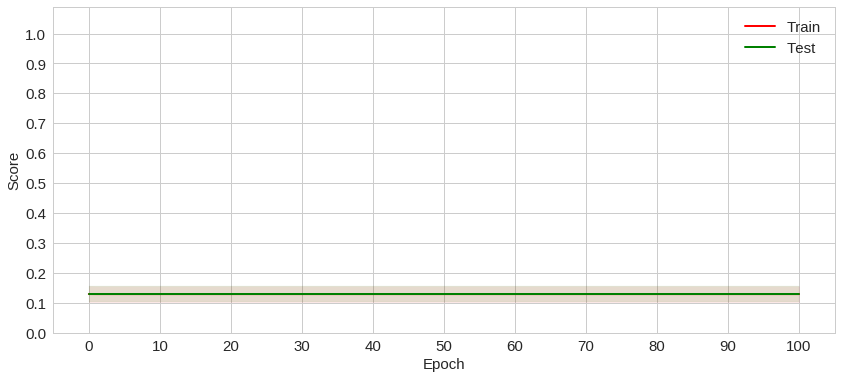

In [38]:
plot_mean_acc(tophist)

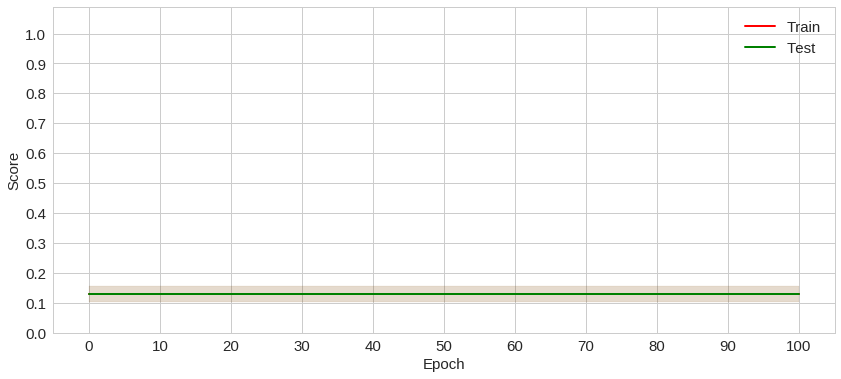

In [39]:
plot_mean_acc(hist)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

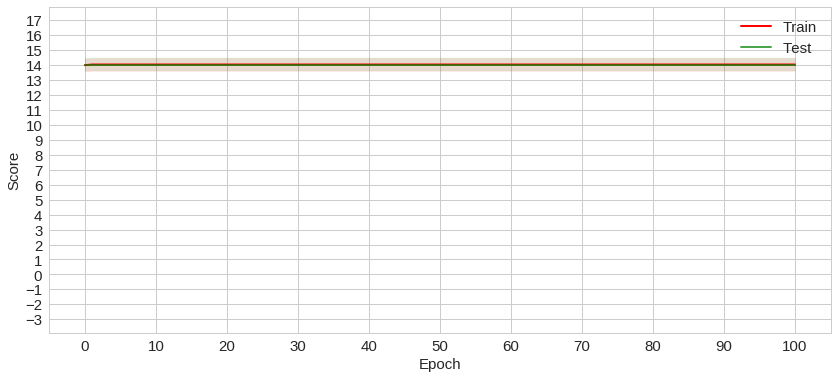

In [41]:
plot_mean_loss(tophist)

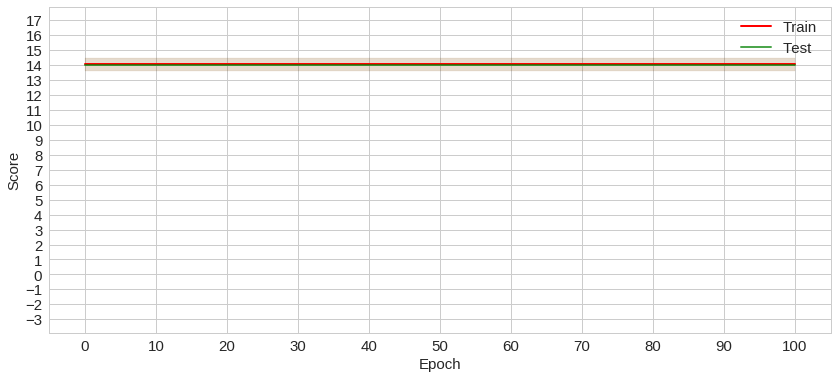

In [42]:
plot_mean_loss(hist)